# Imports and Data

In [464]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
unfiltered['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = unfiltered['uk12'].append(df)

L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
calls['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = calls['uk12'].append(df)
    
    
globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [405]:
calls['uk12']

ego         alter                time  uclock  aclock
0      aC07779270485  C01142661971 2007-03-06 14:40:00       1       0
1      aC07779270485  C01142661971 2007-03-17 19:19:00      12      11
2      aC07779270485  C01142661971 2007-03-30 17:21:00      25      24
3      aC07779270485  C01142661971 2007-04-02 19:28:00      28      27
4      aC07779270485  C01142661971 2007-04-05 11:43:00      30      29
...              ...           ...                 ...     ...     ...
13184  bC07999103487   C7964154172 2007-09-20 13:29:00      18       0
13185  bC07999103487   C7964154172 2007-09-20 14:46:00      18       0
13186  bC07999103487   C7964154172 2007-09-28 22:07:00      27       9
13187  bC07999103487   C7964154172 2007-10-04 23:37:00      33      15
13188  bC07999103487   C7964154172 2007-10-04 23:38:00      33      15

[24488 rows x 5 columns]

In [191]:
for c in ['uk', 'uk2', 'it', 'mit']:
    print(c, min(unfiltered[c]['time']), max(unfiltered[c]['time']), max(unfiltered[c]['uclock']) - min(unfiltered[c]['uclock']))

uk 2007-03-05 13:17:00 2008-08-31 20:13:00 545
uk2 2007-09-01 15:05:00 2008-08-31 20:13:00 365
it 2013-02-01 08:03:16 2014-12-31 23:46:21 698
mit 2010-02-27 17:05:20 2011-07-16 19:33:13 504


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [2]:
# with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
#     tmpdff = pickle.load(handle)
#     handle.close()
    
# with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
#     tmplives = pickle.load(handle)
#     handle.close()
    
# pikachu = {}
# for it in ['it1', 'it2']:
#     pikachu[it] = {}
#     for ego in tmpdff[it][60].keys():
#         thekey = {"it1": "a", "it2": "b"}
#         pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
#         pikachu['it'] = pikachu.get('it', {})
#         pikachu['it'][f'{thekey[it]}{ego}'] = {}
#         pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

# raichu = {}
# for it in ['it1', 'it2']:
#     raichu[it] = {}
#     for ego in tmplives[it][60].keys():
#         thekey = {"it1": "a", "it2": "b"}
#         raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
#         raichu['it'] = raichu.get('it', {})
#         raichu['it'][f'{thekey[it]}{ego}'] = {}
#         raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [3]:
# lives = {}
# forkey = {'uk1': 'a', 'uk2': 'b'}
# for c in ['uk1', 'uk2', 'mit', 'it', 'uk']:
#     if c in ['uk1', 'uk2']:
#         lf = pc.lives_dictionary(calls[''])
#         lives[c] = {}
#         for ego in lf.keys():
#             thekey = f'{forkey[c]}{ego}'
#             lives[c][thekey] = lf[ego]
#         lives['all'] = lives.get('all', {})
#         lives['all'].update(lives[c])
#     elif c == 'uk':
#         lives[c] = {}
#         for u in ['uk1', 'uk2']:
#             lives[c].update(lives[u])
#     else:
#         lives[c] = pc.lives_dictionary(calls[c])
#         lives['all'] = lives.get('all', {})
#         lives['all'].update(lives[c])

In [465]:
lives = {}
lives['all'] = {}
for c in ['uk2', 'it', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    lives['all'].update(lives[c])

In [5]:
# dffcomb = {}
# # for c in ['it', 'it1', 'it2']:
# #     dffcomb[c] = pikachu[c]

# dffcomb['uk'] = {}
# dffcomb['it'] = {}
# for c in ['uk1', 'uk2', 'it1', 'it2']:
#     cdf = calls[c].loc[calls[c]['aclock'] <= 300]
#     ddf = pc.get_f(cdf, 'all', 15, 10)
#     dffcomb[c] = {}
#     forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
#     for ego in ddf.keys():
#         dffcomb[c][f'{forkey[c]}{ego}'] = {}
#         for alter in ddf[ego].keys():
#             df1 = ddf[ego][alter]
#             df2 = df1.loc[(df1['alpha'] <= 20)]
#             dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
#             if c in ['uk1', 'uk2']:
#                 dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
#                 dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
#             else:
#                 dffcomb['it'][f'{forkey[c]}{ego}'] = dffcomb['it'].get(f'{forkey[c]}{ego}', {})
#                 dffcomb['it'][f'{forkey[c]}{ego}'][alter] = dffcomb['it'][f'{forkey[c]}{ego}'].get(alter, df2)
            
# dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [6]:
# limits = [(0, 50), (100, 150), (200, 250)]

In [7]:
# limits = [(0, 50), (100, 150), (200, 250)]
# limsit = [(0, 50), (200, 250), (300, 350)]

In [469]:
limits = {}
for c in ['uk2', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [8]:
# t0 = dt.datetime.now()

# fig1 = {}
# for c in ['uk', 'uk2', 'it', 'mit']:
#     fig1[c] = {}
#     for i in range(3):
#         fig1[c][i] = {}
#         fig1[c][i]['f'] = pc.get_avgfa(dffcomb[c], lives[c], limits[i][0], limits[i][1])
#         fig1[c][i]['fi'] = {}
#         for ego in dffcomb[c].keys():
#             tmp = {ego: dffcomb[c][ego]}
#             fig1[c][i]['fi'][ego] = pc.get_avgfa(tmp, lives[c], limits[i][0], limits[i][1])
        
# print(f'Took {dt.datetime.now() - t0}')

In [477]:
t0 = dt.datetime.now()
fig1 = {}
for c in ['uk2', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15, countalters=True)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:01.365846


In [556]:
dashed = {}
for c in ['uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk2=====================
[[1, 2], [0.663175464631242, 0.663175464631242], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.663175464631242) -- (axis cs: 2, 0.663175464631242);
[[1, 9], [1.87373430853823, 1.87373430853823], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.87373430853823) -- (axis cs: 9, 1.87373430853823);
[[1, 16], [2.4968990752451297, 2.4968990752451297], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.448535988086695) -- (axis cs: 13, 2.448535988086695);
=======================it=====================
[[1, 2], [0.551795638030544, 0.551795638030544], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
[[1, 12], [0.7250957211167651, 0.7250957211167651], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.7250957211167651) -- (axis cs: 12, 0.7250957211167651);
[[1, 23], [2.341541665493771, 2.341541665493771], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2

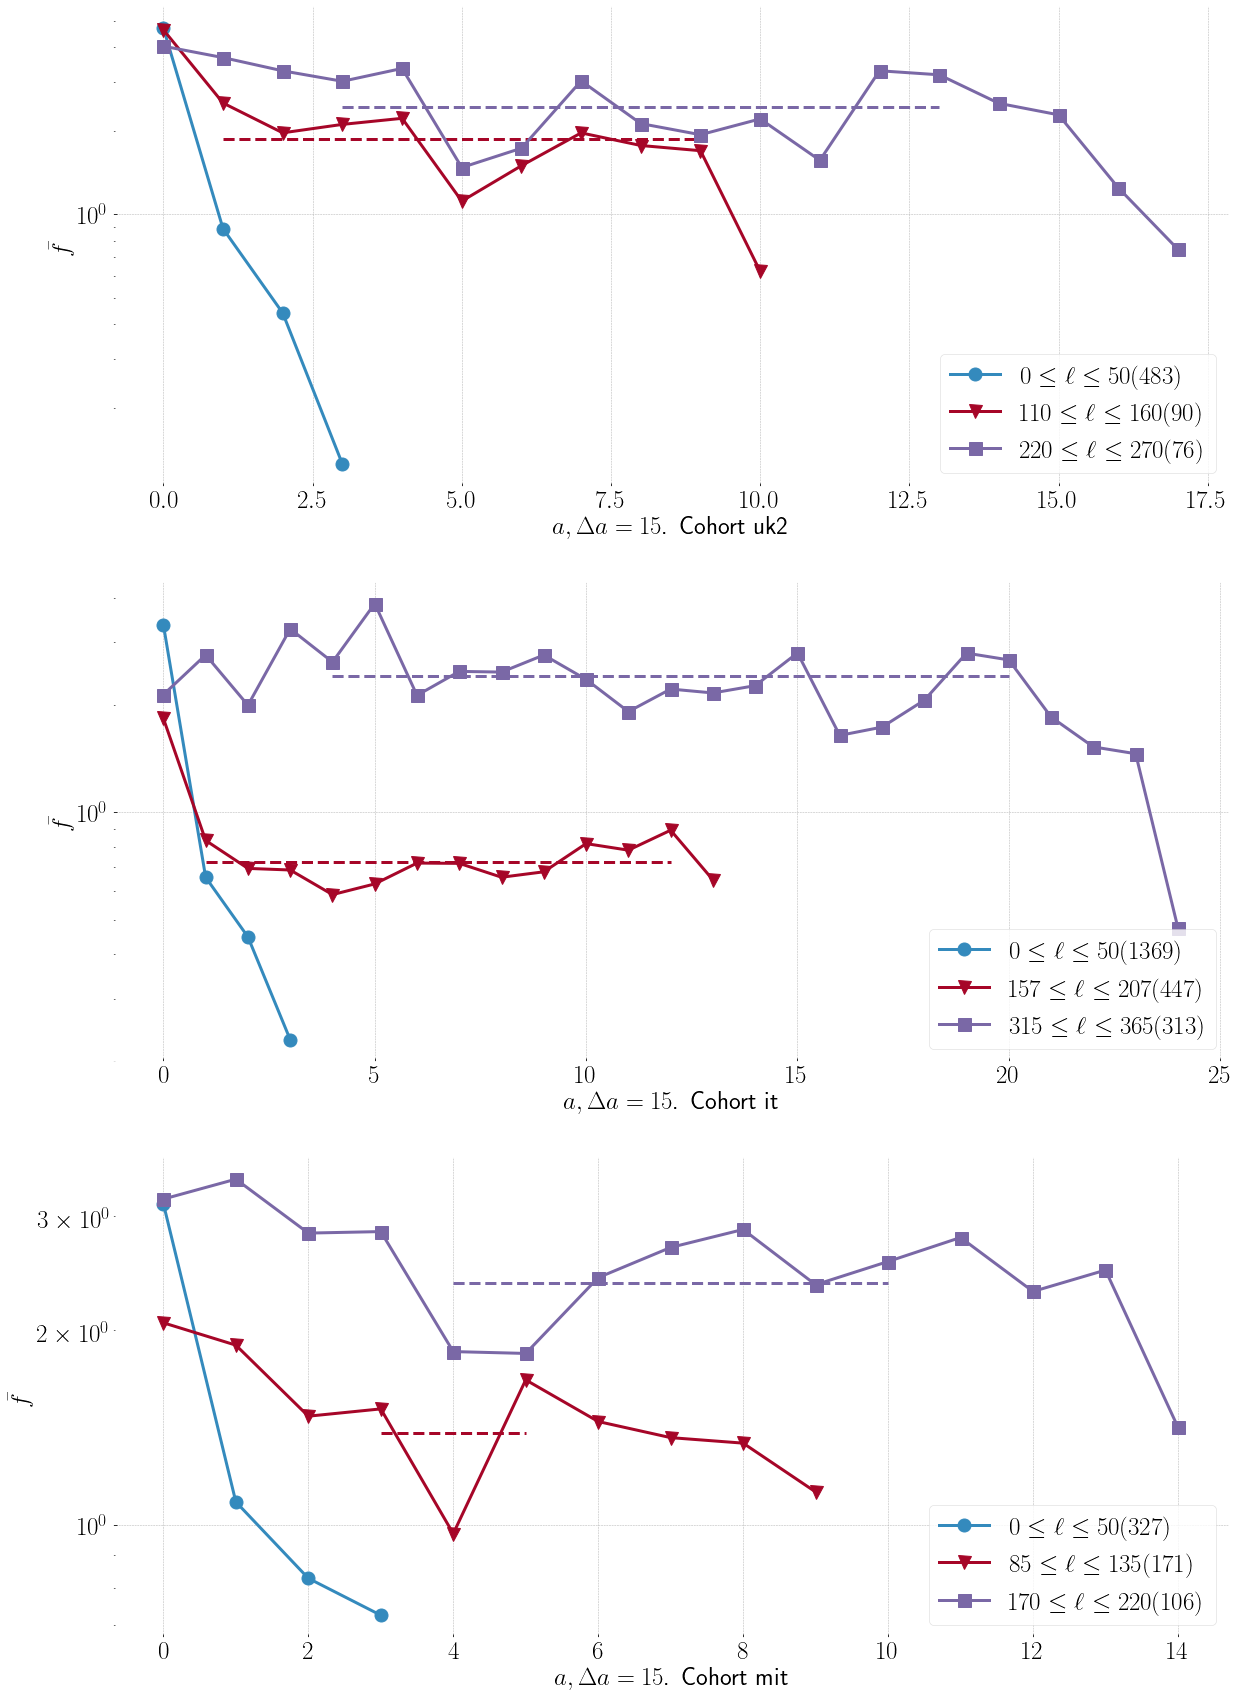

In [472]:
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in ['uk2', 'it', 'mit']:
    plt.subplot(3, 1, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]} ({fig1[c][i]["nalters"]})$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [473]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]['f']
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

# Fig 2

In [486]:
ksp = {}
for c in ['uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [488]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

In [489]:
for c in ksp.keys():
    for k in ksp[c].keys():
        lista = ksp[c][k]
        count = 0
        for i in lista:
            if i < 0.05:
                count += 1
        print(c, k, count/len(lista))

uk2 m 0.0
uk2 l 0.041666666666666664
it m 0.00847457627118644
it l 0.02247191011235955
mit m 0.0
mit l 0.01694915254237288


In [490]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [491]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [492]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

In [493]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [498]:
cols = ['uk2m', 'itm', 'mitm', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,1,4,7]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 3]
b = tmp2.loc[tmp2.index >= 3]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [499]:
a

c  pos      mean       sem
idx                               
0    uk2m    0  1.727530  1.765591
1     itm    3  0.871059  0.619334
2    mitm    6  1.546408  1.506293

In [500]:
dashed

{'uk2': {0: [[1, 2], [0.663175464631242, 0.663175464631242]],
  1: [[1, 9], [1.87373430853823, 1.87373430853823]],
  2: [[3, 13], [2.448535988086695, 2.448535988086695]]},
 'it': {0: [[1, 2], [0.551795638030544, 0.551795638030544]],
  1: [[1, 12], [0.7250957211167651, 0.7250957211167651]],
  2: [[4, 20], [2.410915817340646, 2.410915817340646]]},
 'mit': {0: [[1, 2], [0.9565583127190271, 0.9565583127190271]],
  1: [[3, 5], [1.3858107036852683, 1.3858107036852683]],
  2: [[4, 10], [2.365495875341885, 2.365495875341885]]}}

# Fig 3 with resampling

In [22]:
# dffsurv = {}
# dffsurv['all'] = {}
# for c in dffcomb.keys():
#     if c in ['it1', 'it2', 'uk1', 'uk2', 'mit']:
#         dffsurv['all'].update(dffcomb[c])
#     if c in ['uk', 'uk2', 'it', 'mit']:
#         dffsurv[c] = dffcomb[c]

In [23]:
# fig3 = {}
# for c in dffsurv.keys():
#     fig3[c] = pc.get_survival(dffsurv[c], alphafixed=(2,3), externalell=lives[c], lambdamax=25)

In [24]:
# plt.xlabel(r'$\ell, \Delta \ell = 10$')
# plt.ylabel(r'$P$')
# for i in range(5):
#     plt.plot(fig3['all'][i].index, fig3['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
# plt.legend()

In [25]:
# tmp = pd.DataFrame({'lc': list(fig3['all'][0].index)})
# for s in range(6):
#     df = fig3['all'][s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

## Using an alternative function

In [26]:
# callsurv = {}
# callsurv['all'] = pd.DataFrame()
# callsurv['uk'] = pd.DataFrame()
# callsurv['it'] = pd.DataFrame()
# for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
#     df = calls[c].loc[calls[c]['aclock'] <= 300]
#     if c != 'mit':
#         if c in ['uk1', 'it1']:
#             df['ego'] = df['ego'].map(lambda i: 'a'+str(i))
#         elif c in ['uk2', 'it2']:
#             df['ego'] = df['ego'].map(lambda i: 'b'+str(i))
#         callsurv[c] = df
#         if c in ['uk1', 'uk2']:
#             callsurv['uk'] = callsurv['uk'].append(df)
#         elif c in ['it1', 'it2']:
#             callsurv['it'] = callsurv['it'].append(df)
#         callsurv['all'] = callsurv['all'].append(df)
#     else:
#         callsurv[c] = df
#         callsurv['all'] = callsurv['all'].append(df)

In [501]:
calls['all'] = pd.DataFrame()
for c in calls.keys():
    if c in ['uk2', 'it', 'mit']:
        calls['all'] = calls['all'].append(calls[c])

In [502]:
len(calls['all']) == len(calls['uk2']) + len(calls['mit']) + len(calls['it'])

True

In [503]:
fig3b = {}
for c in ['all', 'uk2', 'it', 'mit']:
    fig3b[c] = pc.get_survival2(calls[c], 30, 60, maxell = 220, base = 3)

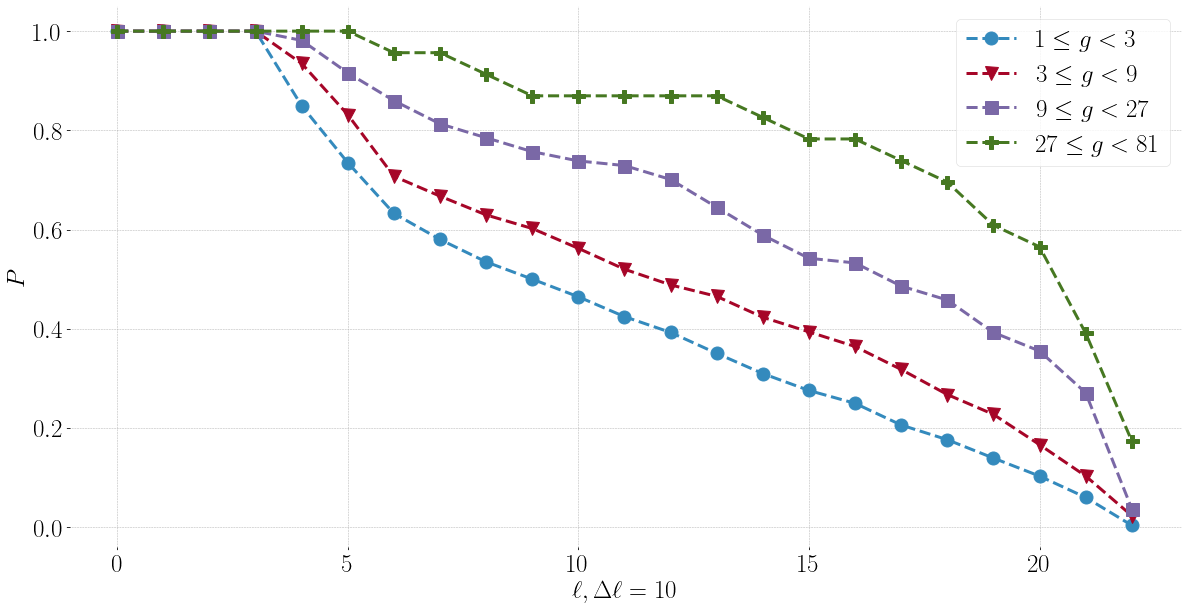

In [505]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(4):
    plt.plot(fig3b['all'][i].index, fig3b['all'][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${3**i} \leq g < {3**(i + 1)}$')
plt.legend()

In [254]:
tmp = pd.DataFrame({'lc': list(fig3b['all'][0].index)})
for s in range(4):
    df = fig3b['all'][s]
    tmp[f'p{int(s)}'] = df['p']
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

# Fig 4 with resampling

In [526]:
callsUM = pd.DataFrame()
for c in ['uk2', 'mit']:
    callsUM = callsUM.append(calls[c])
    
surv_cont = pc.get_survival2(callsUM, 30, 60, maxell=220, base = 3)

In [527]:
tmp = pd.DataFrame()
for s in range(4):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 3**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [528]:
points_it = pc.get_survival2(calls['it'], 30, 60, binned=False, maxell=220)

tmp = pd.DataFrame()
for s in points_it.keys():
    if s < 3**4 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# SI with resampling

## Using different values for $\Delta t_w$

In [529]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk2', 'it', 'mit']:
    S1[c] = {}
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    for tw in [10, 30, 50, 60, 90]:
        S1[c][tw] = {}
        cdf = pc.apply_filters(df, tw)
        for lamb in range(3):
            S1[c][tw][lamb] = pc.get_fal(cdf, limits[c][lamb][0], limits[c][lamb][1], 15)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:08.043041


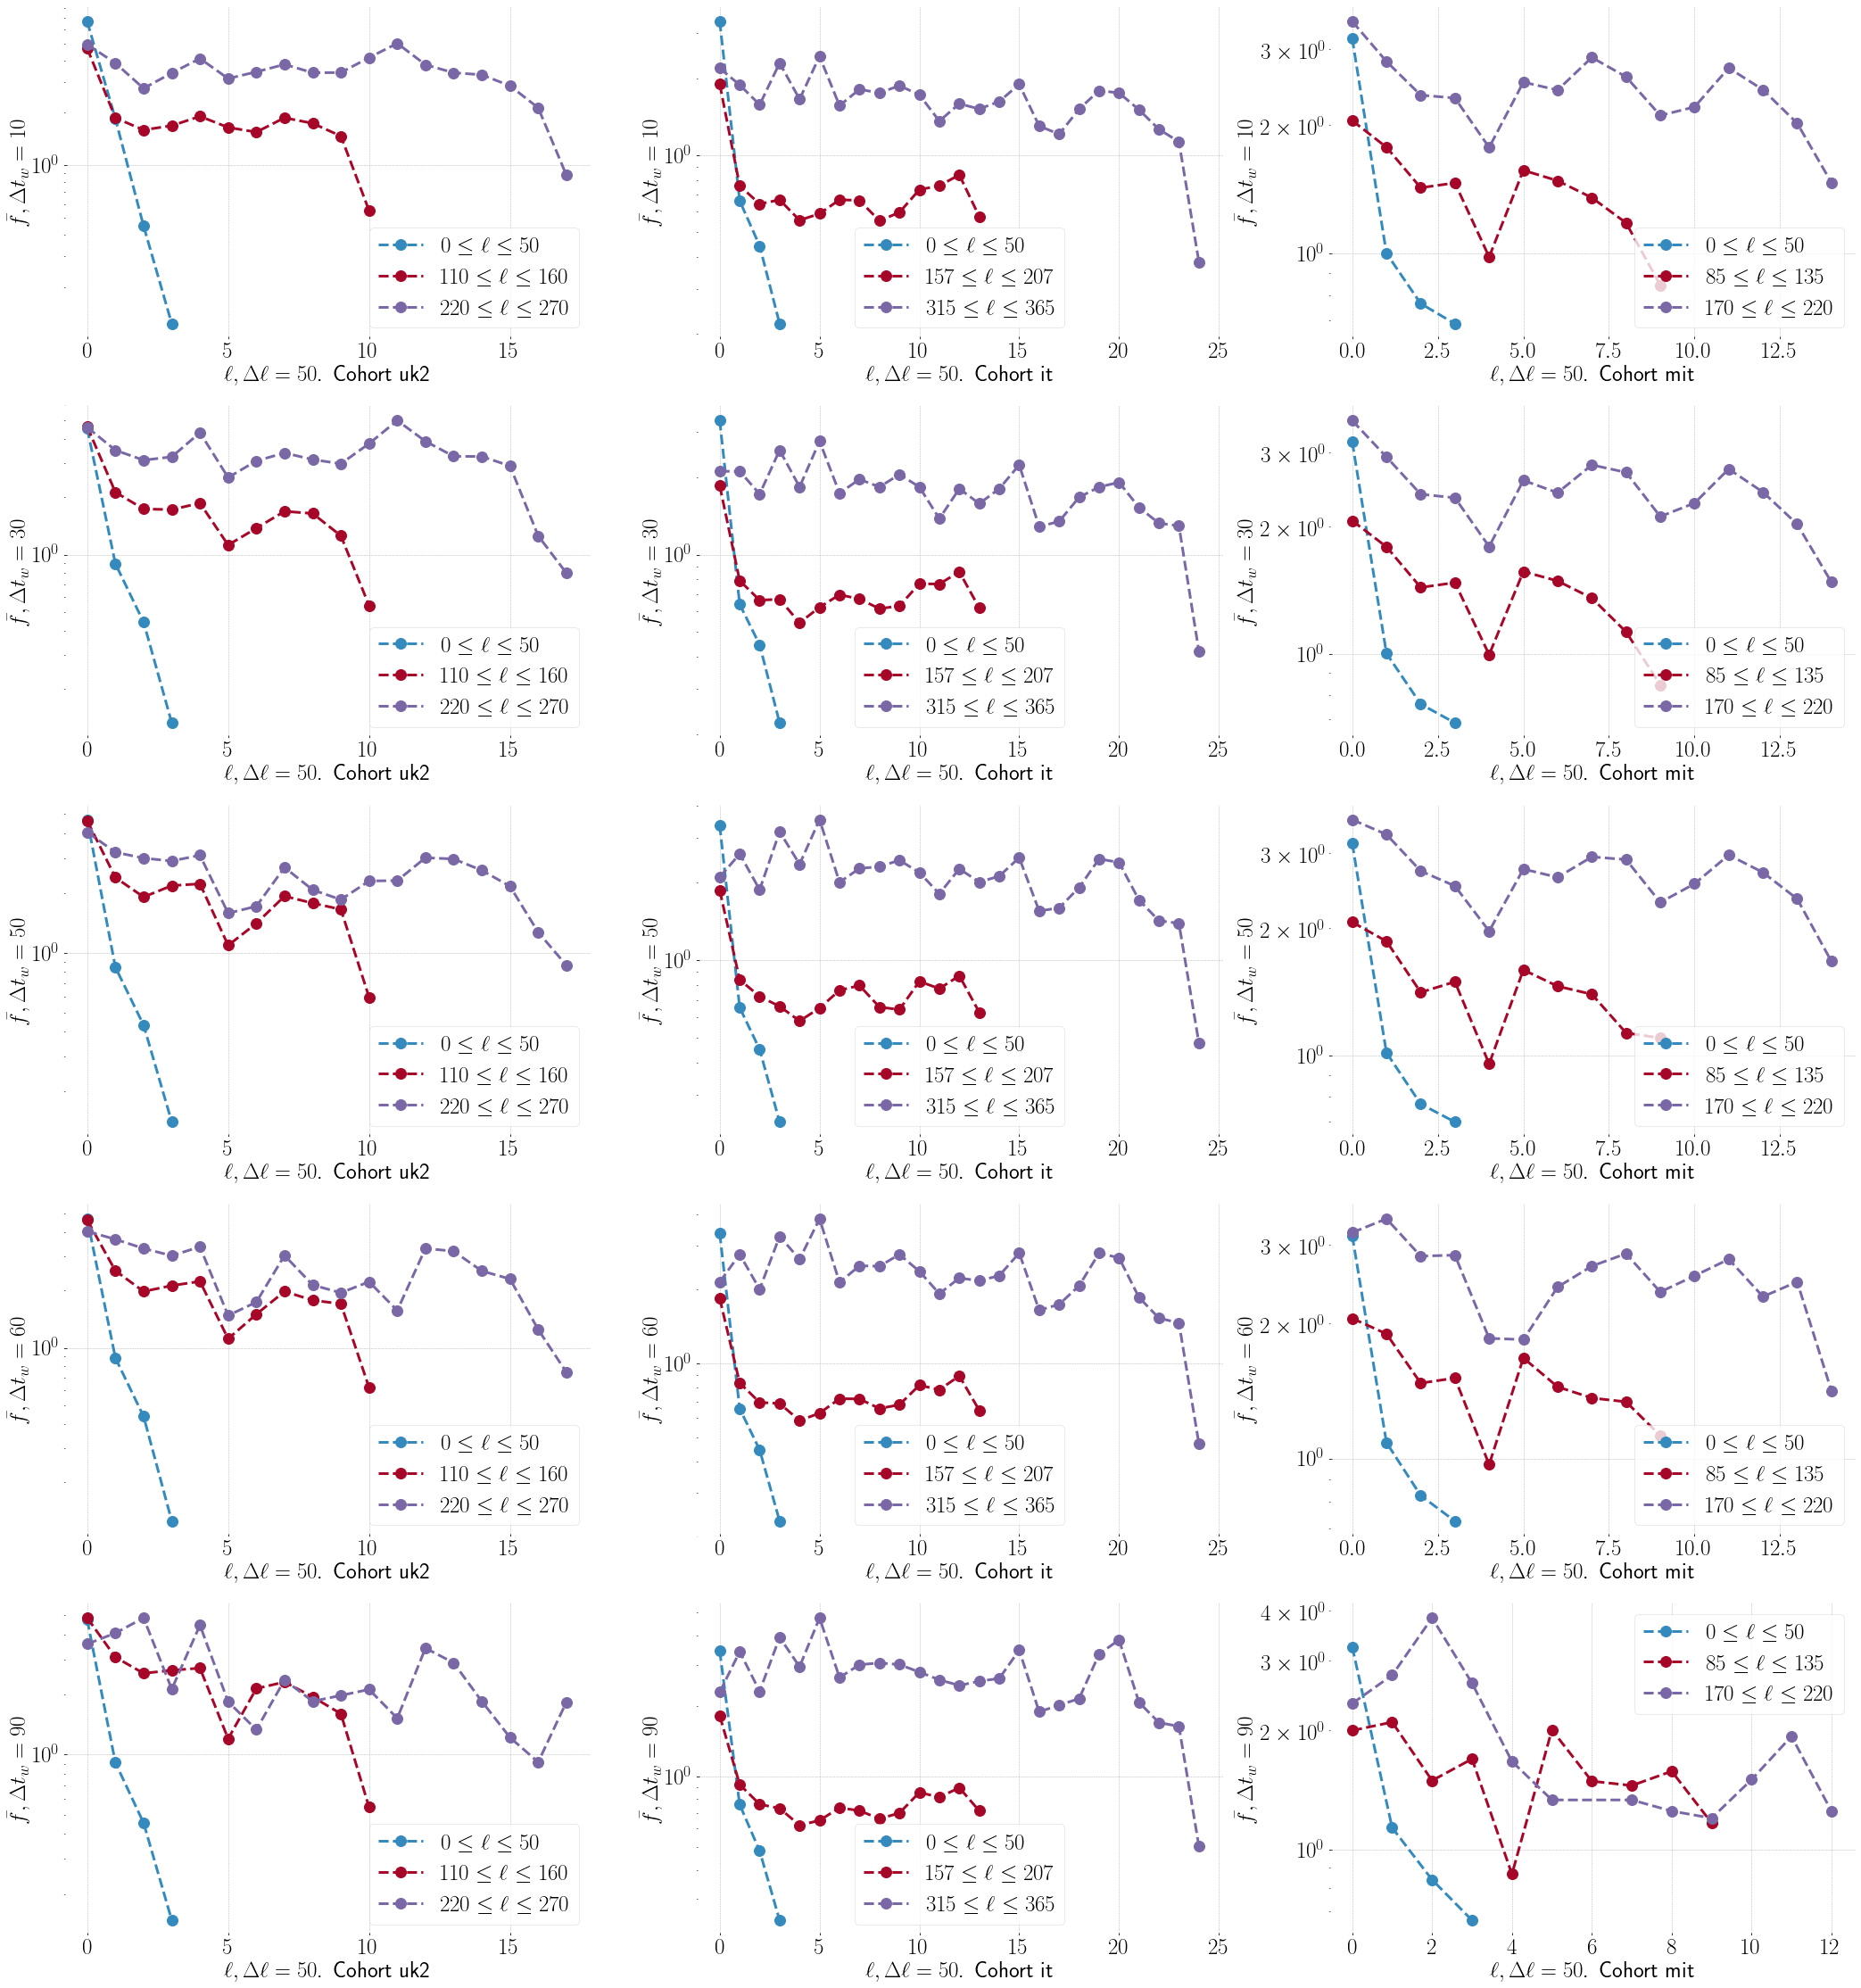

In [531]:
plt.figure(figsize=(12*3, 8*6))
p = 1
for Dt in S1['uk2'].keys():
    for c in S1.keys():
        plt.subplot(6, 3, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[c][lamb][0]}\leq \ell \leq {limits[c][lamb][1]}$')
        plt.legend()
        p += 1

In [532]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

## Different values for $\Delta \ell$

In [533]:
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [535]:
lims = {}
for c in limits.keys():
    lims[c] = {}
    for i in range(3):
        lims[c][i] = [limits[c][i]] + [(limits[c][i][0], limits[c][i][0] + Dl) for Dl in [10, 30, 70, 90]]
        
lims


{'uk2': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(110, 160), (110, 120), (110, 140), (110, 180), (110, 200)],
  2: [(220, 270), (220, 230), (220, 250), (220, 290), (220, 310)]},
 'it': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(157, 207), (157, 167), (157, 187), (157, 227), (157, 247)],
  2: [(315, 365), (315, 325), (315, 345), (315, 385), (315, 405)]},
 'mit': {0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
  1: [(85, 135), (85, 95), (85, 115), (85, 155), (85, 175)],
  2: [(170, 220), (170, 180), (170, 200), (170, 240), (170, 260)]}}

In [536]:
S2 = {}
for c in ['uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            S2[c][i][j] = pc.get_fal(calls[c], lims[c][i][j][0], lims[c][i][j][1], 15)

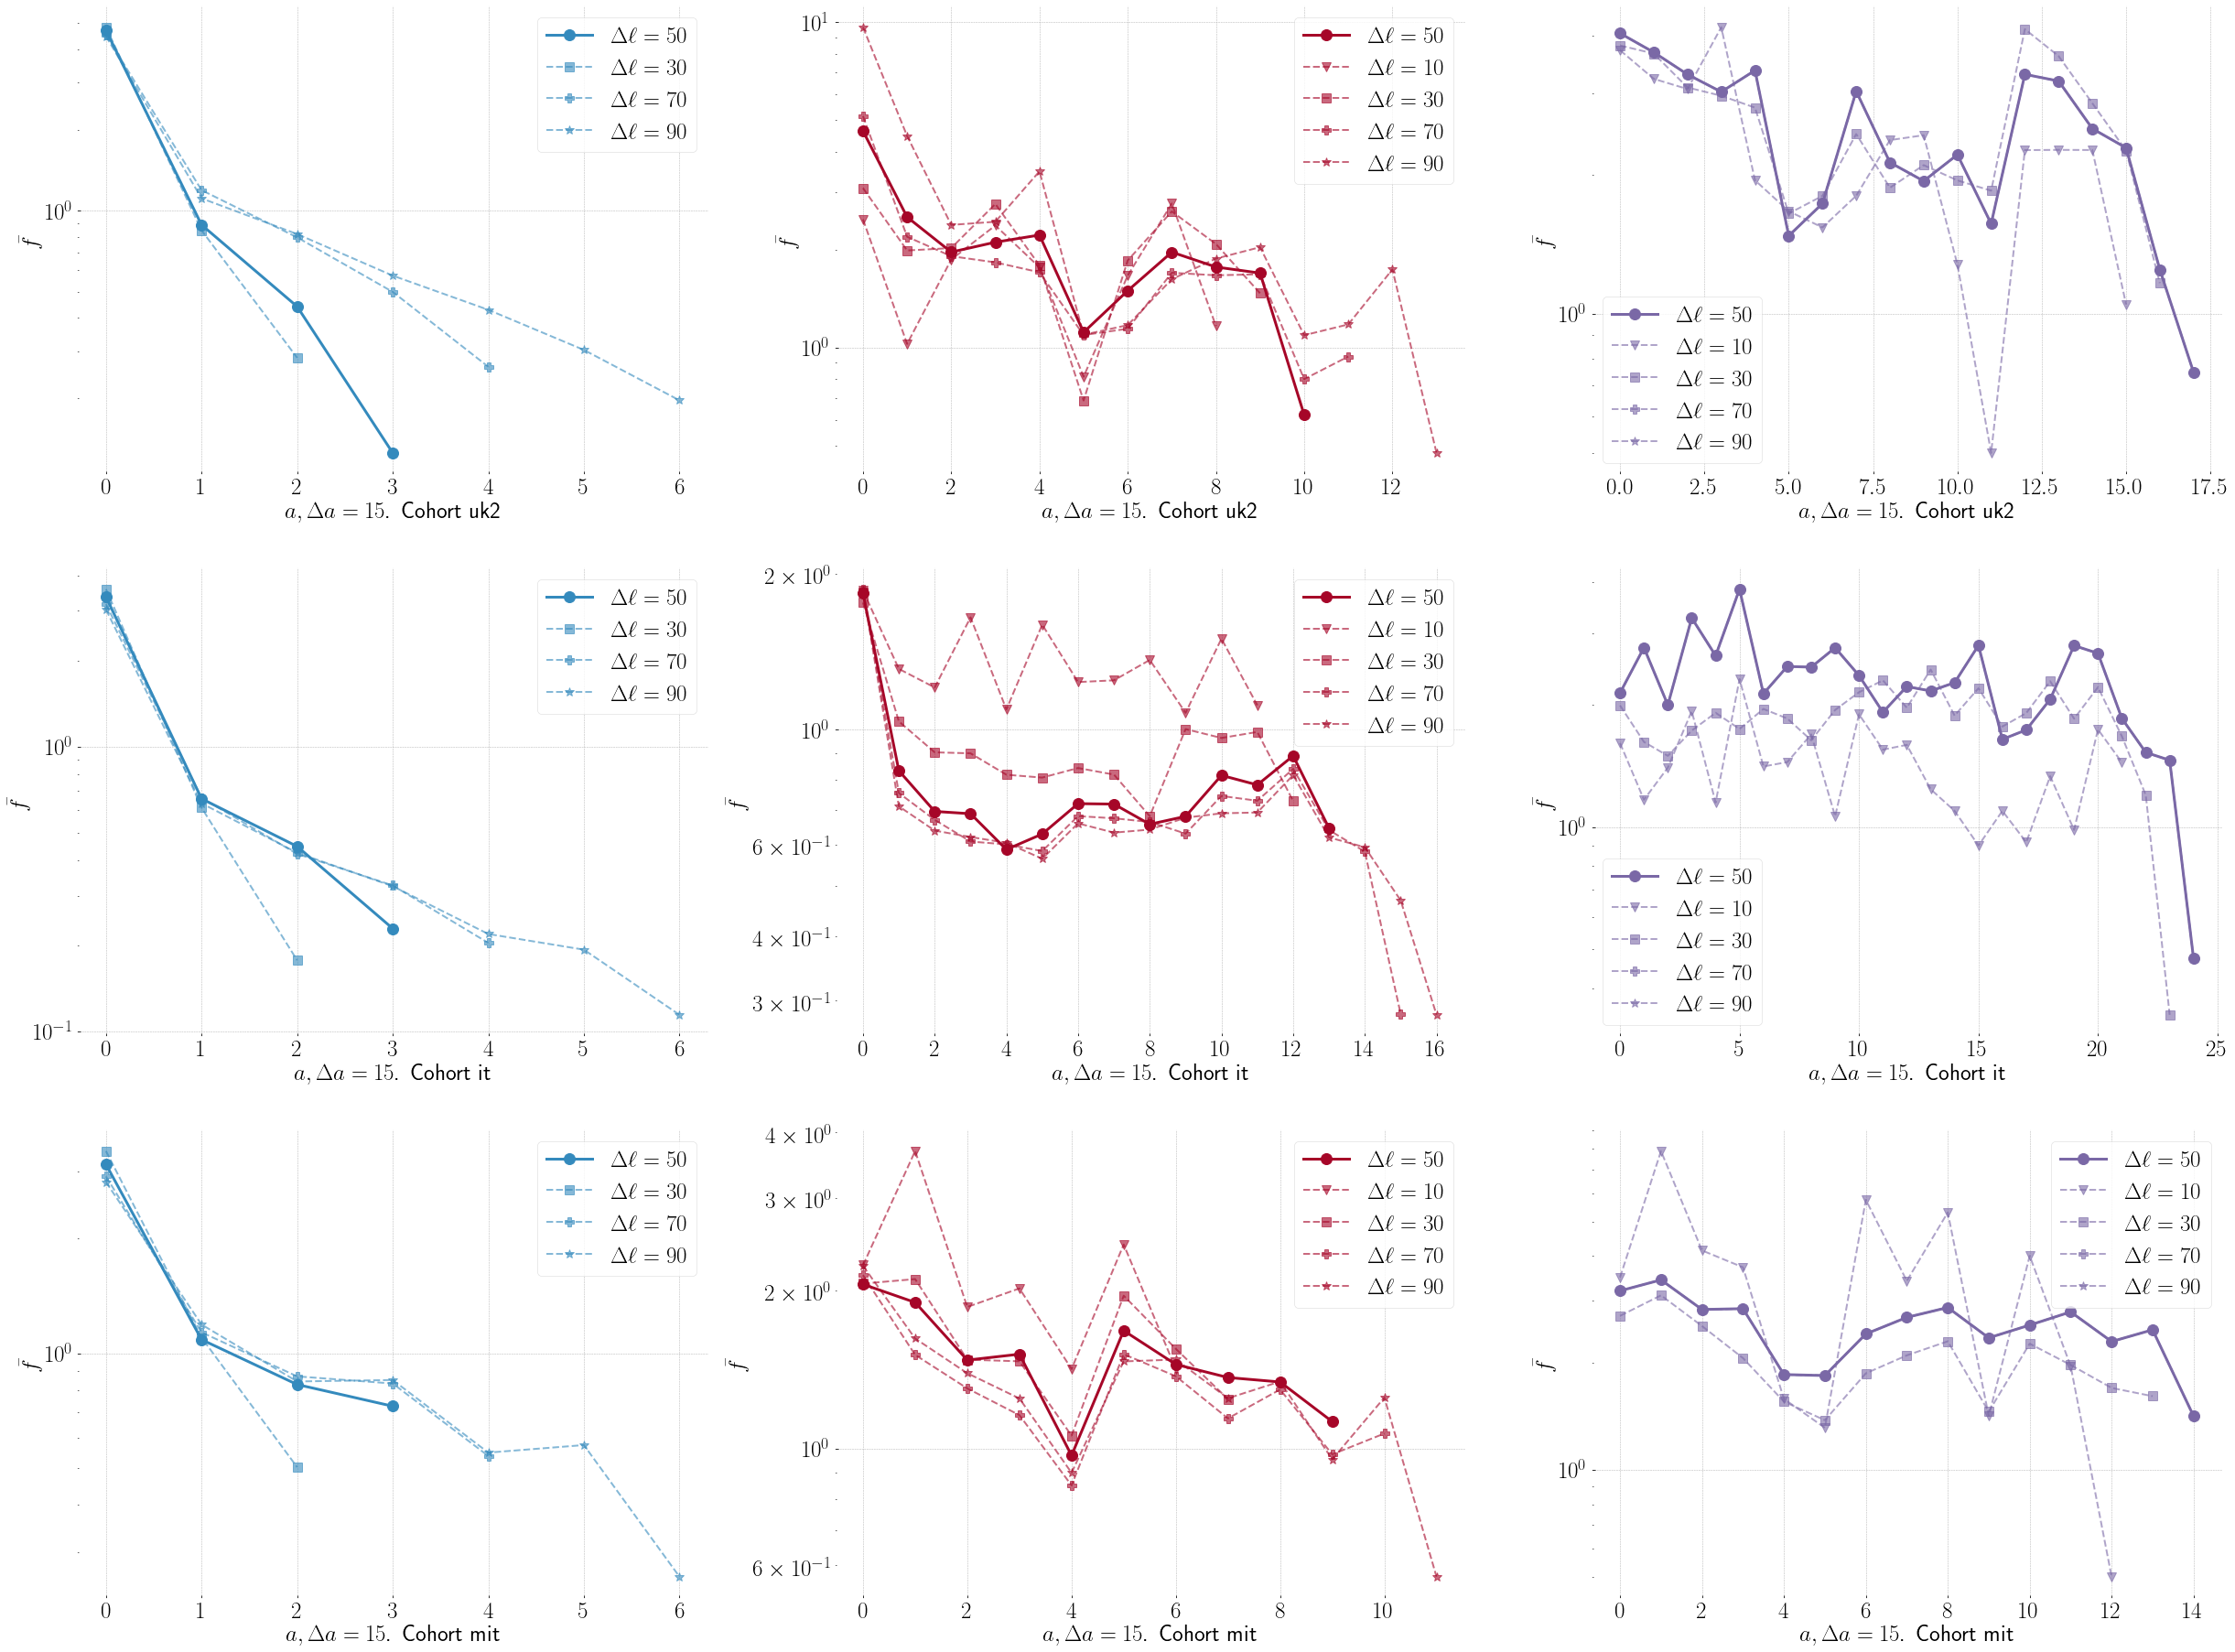

In [537]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(3, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [538]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1: variations of $\Delta a$

In [539]:
t0 = dt.datetime.now()
Deltaa = {}
for c in ['uk2', 'it', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            Deltaa[c][Da][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], Da)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:08.252908


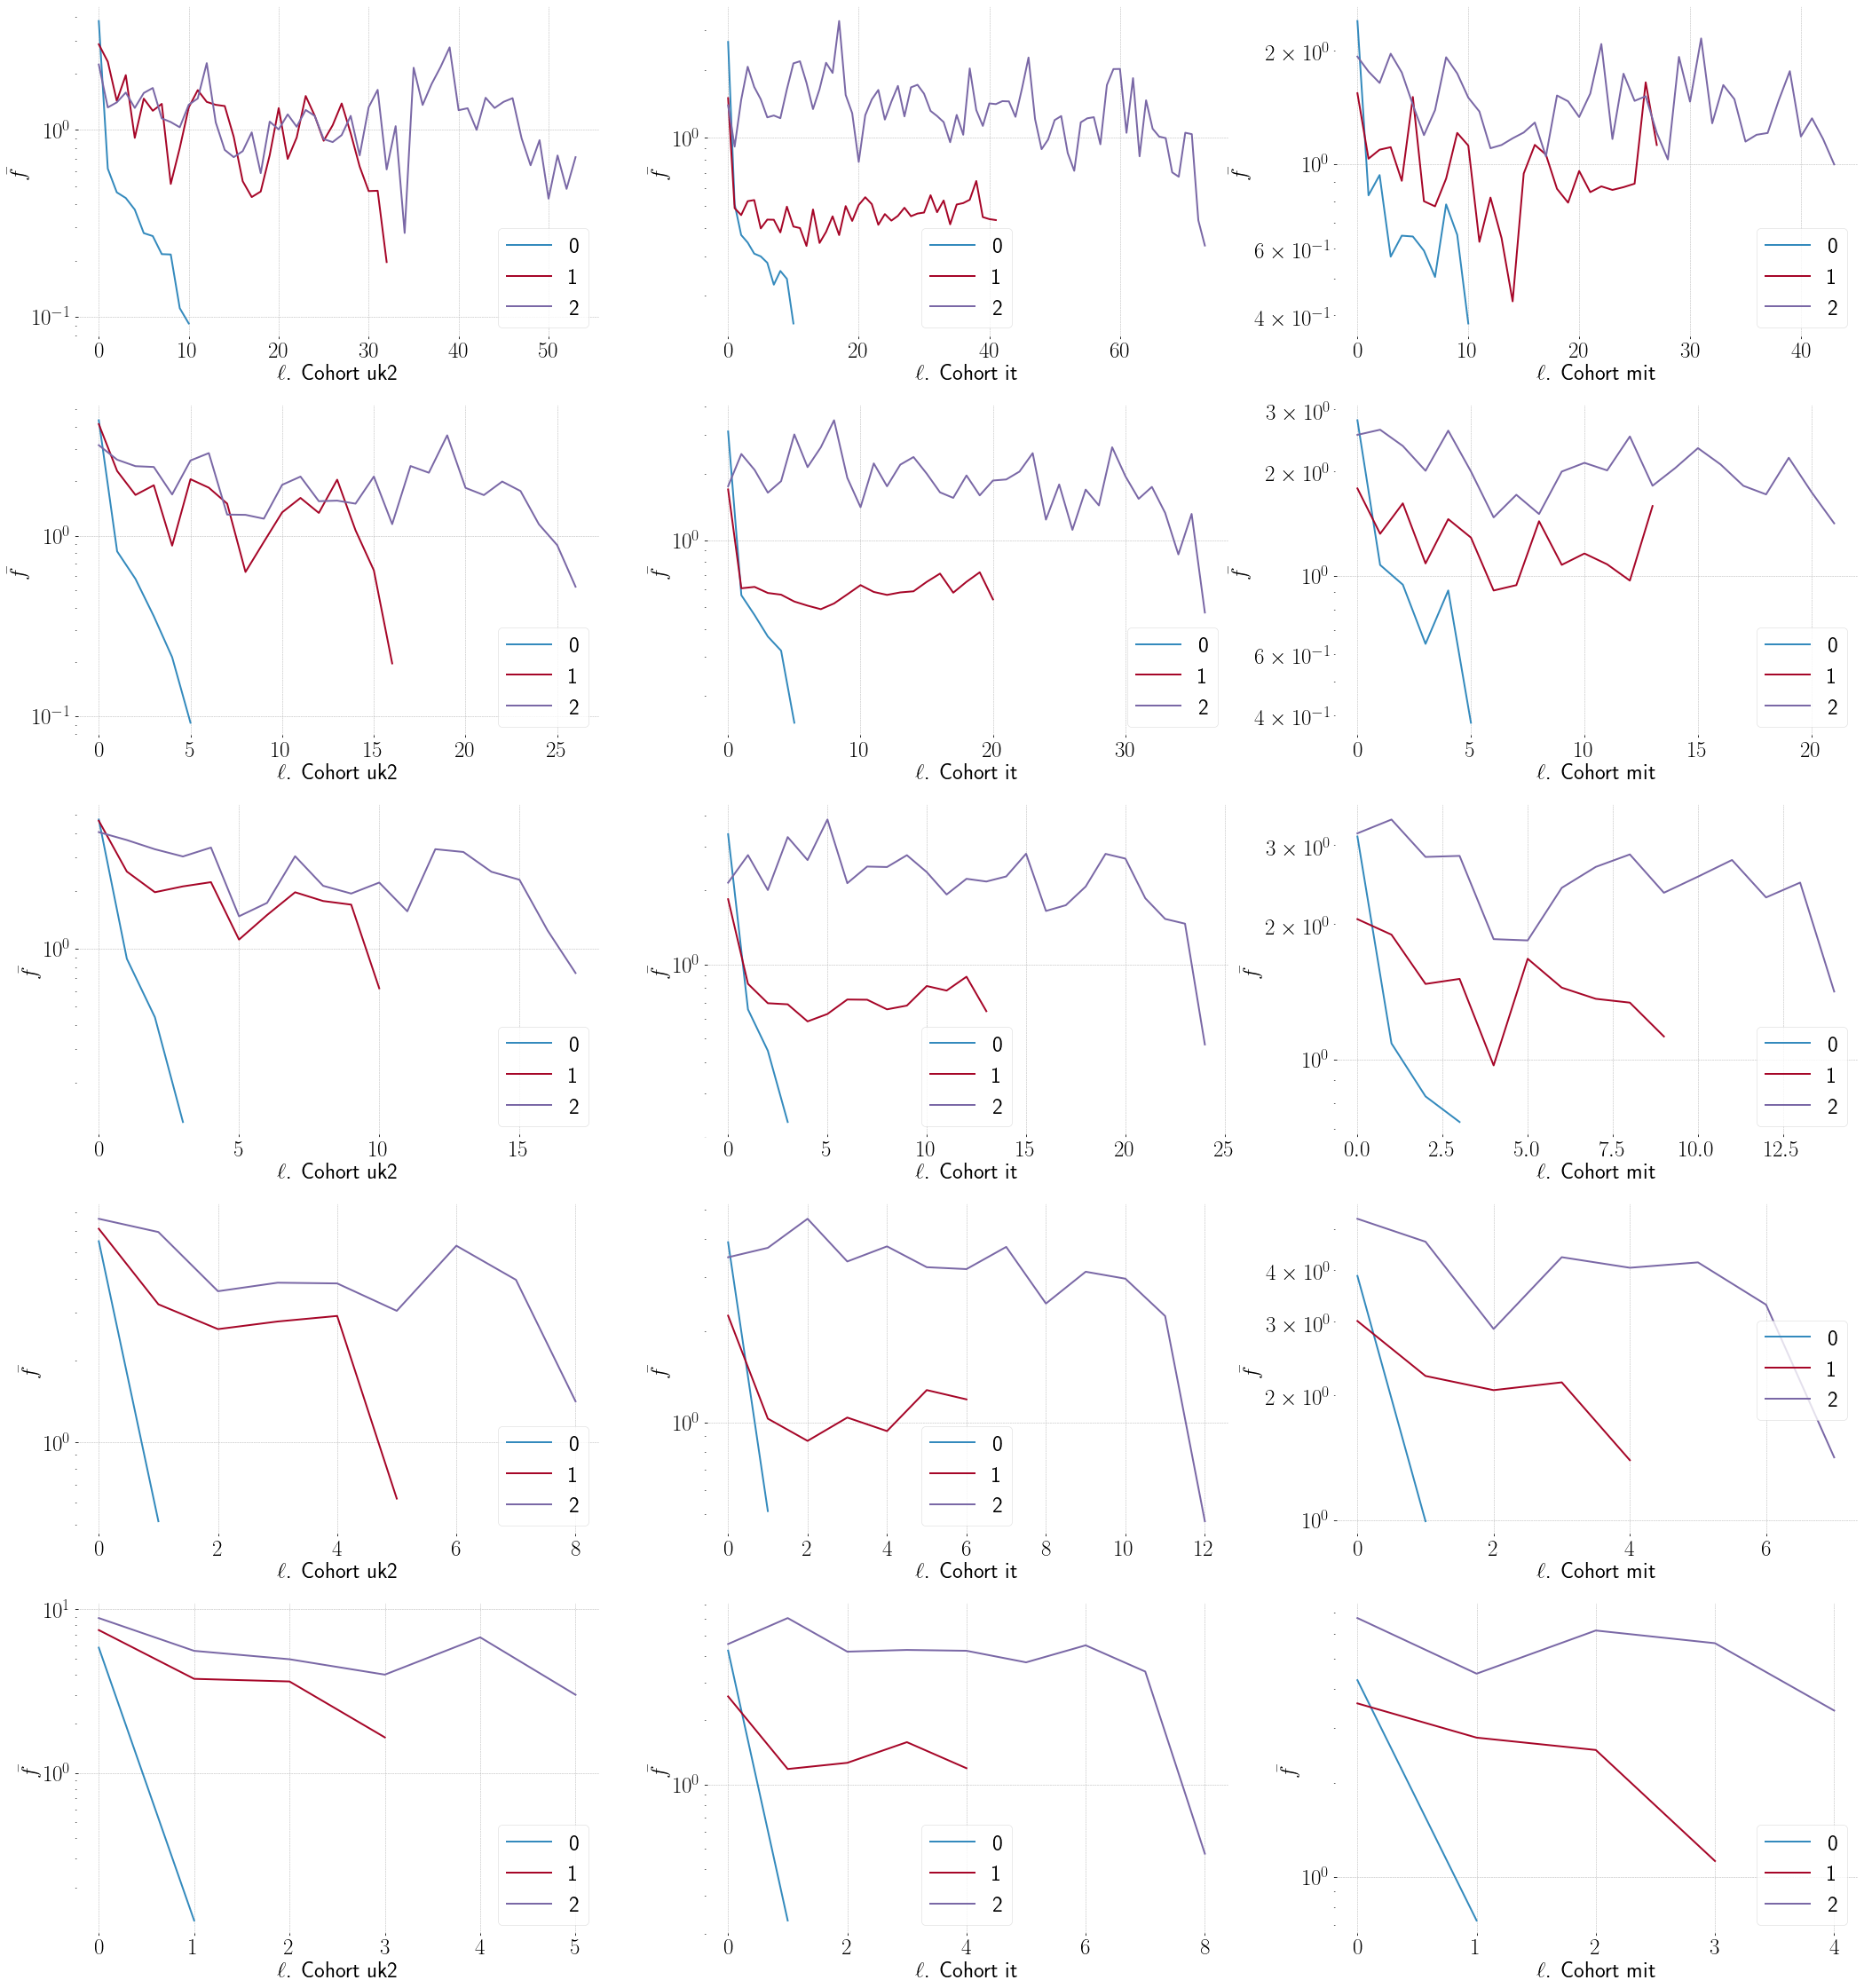

In [541]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk2', 'it', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(fr'$\ell$. Cohort {c}')
        plt.ylabel(r'$\bar{f}$')
        plt.semilogy()
        for i in range(3):
            plt.plot(Deltaa[c][Da][i]['f'].index, Deltaa[c][Da][i]['f']['f'], label=f'{i}')
        plt.legend()
        p += 1

In [542]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]['f']
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [543]:
useegos = []
for e in fig1['mit'][2]['fi'].keys():
    if len(fig1['mit'][2]['fi'][e].index) >= 10:
        useegos.append(e)

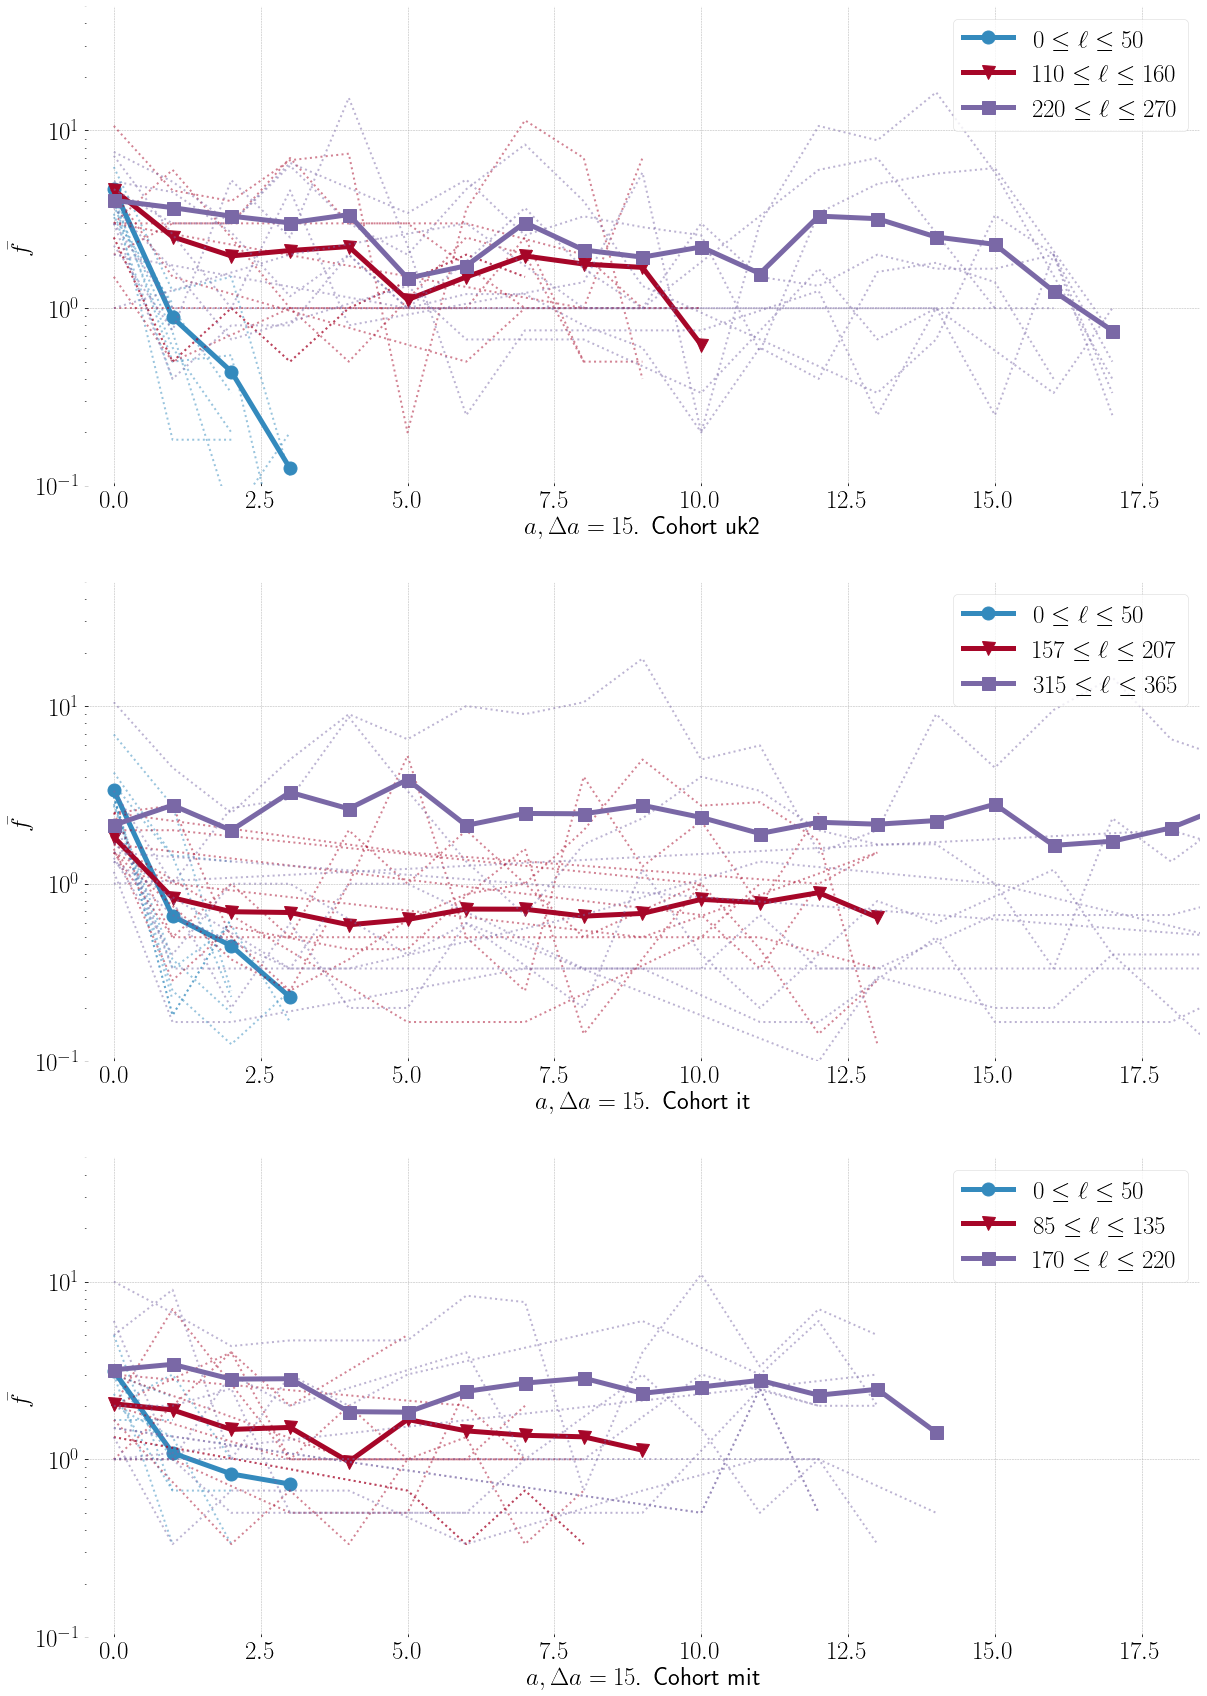

In [546]:
np.random.seed(0)
tmp = pd.DataFrame(index=range(18))
plt.figure(figsize=(20, 10*3))
p = 1
for c in ['uk2', 'it', 'mit']:
    plt.subplot(3, 1, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 18.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        if c != 'sss':
            egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        else:
            egos = np.random.choice(useegos, size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [547]:
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

In [299]:
tmp

uk0avg     uk0e1     uk0e2 uk0e3     uk0e4     uk0e5 uk0e6     uk0e7  \
a                                                                            
0   4.743025  3.192308  3.458333   3.4  4.142857  5.415385   3.4  4.694737   
1   0.860717  1.192308      0.25   0.4  0.785714  0.507692   0.4  0.231579   
2   0.447519  0.269231      0.25   nan  0.214286  0.630769   nan       0.2   
3   0.182031  0.076923  0.041667   nan  0.035714       0.2   nan  0.052632   
4        nan       nan       nan   nan       nan       nan   nan       nan   
5        nan       nan       nan   nan       nan       nan   nan       nan   
6        nan       nan       nan   nan       nan       nan   nan       nan   
7        nan       nan       nan   nan       nan       nan   nan       nan   
8        nan       nan       nan   nan       nan       nan   nan       nan   
9        nan       nan       nan   nan       nan       nan   nan       nan   
10       nan       nan       nan   nan       nan       nan   nan       nan   
11       nan       nan       nan   nan       nan       nan   nan       nan   
12       nan       nan       nan   nan       nan       nan   nan       nan   
13       nan       nan       nan   nan       nan       nan   nan       nan   
14       nan       nan       nan   nan       nan       nan   nan       nan   
15       nan       nan       nan   nan       nan       nan   nan       nan   
16       nan       nan       nan   nan       nan       nan   nan       nan   
17       nan       nan       nan   nan       nan       nan   nan       nan   
18       nan       nan       nan   nan       nan       nan   nan       nan   

    uk0e8 uk0e9  ... mit2e1 mit2e2 mit2e3 mit2e4 mit2e5 mit2e6 mit2e7 mit2e8  \
a                ...                                                           
0    5.25   3.4  ...    1.0    2.0    2.0    1.0    5.0    5.0    1.0    1.0   
1   2.125   0.4  ...    nan    4.0    2.0    1.0    9.0    3.0    1.0    2.0   
2    0.25   nan  ...    nan    1.5    2.5    1.0    1.0    7.0    1.0    7.0   
3   0.125   nan  ...    nan    4.0    0.5    nan    3.0    4.0    nan    2.0   
4     nan   nan  ...    1.0    nan    nan    1.0    2.0    6.0    1.0    4.0   
5     nan   nan  ...    3.0    nan    nan    nan    3.0    4.0    nan    2.0   
6     nan   nan  ...    nan    4.0    nan    1.0    nan    nan    1.0    1.0   
7     nan   nan  ...    nan    1.5    nan    1.0    nan    nan    1.0    4.0   
8     nan   nan  ...    nan    4.5    nan    nan    nan    3.0    nan    4.0   
9     nan   nan  ...    nan    nan    0.5    1.0    6.0    1.0    1.0    2.0   
10    nan   nan  ...    nan    1.5    nan    nan    nan    2.0    nan    2.0   
11    nan   nan  ...    1.0    5.0    2.5    nan    3.0    2.0    nan    4.0   
12    nan   nan  ...    nan    5.5    2.0    nan    6.0    2.0    nan    3.0   
13    nan   nan  ...    1.0    nan    2.0    1.0    2.0    nan    1.0    3.0   
14    nan   nan  ...    nan    nan    nan    nan    nan    nan    nan    nan   
15    nan   nan  ...    nan    nan    nan    nan    nan    nan    nan    nan   
16    nan   nan  ...    nan    nan    nan    nan    nan    nan    nan    nan   
17    nan   nan  ...    nan    nan    nan    nan    nan    nan    nan    nan   
18    nan   nan  ...    nan    nan    nan    nan    nan    nan    nan    nan   

   mit2e9   mit2e10  
a                    
0     6.0       2.0  
1     5.0       2.0  
2     2.0  1.333333  
3     1.0  1.666667  
4     nan       1.0  
5     nan       1.0  
6     nan  1.333333  
7     2.0  1.666667  
8     8.0  0.666667  
9     3.0       1.0  
10    2.0       1.0  
11    5.0  1.333333  
12    1.0  2.333333  
13    3.0  2.666667  
14    nan       nan  
15    nan       nan  
16    nan       nan  
17    nan       nan  
18    nan       nan  

[19 rows x 132 columns]

## $b(\ell)$ by cohort

Only when it converges. I may try to  bin the values of $b$ to make it smoother. Also, I will calculate the same measurement considering a combined cohort.

In [ ]:
# dffcomb['all'] = {}
# for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
#     dffcomb['all'].update(dffcomb[c])

In [506]:
t0 = dt.datetime.now()
b = {}
b2 = {}
converge = {}
converge2 = {}
nalt = {}
nego = {}
for c in ['uk2', 'it', 'mit', 'all']:
    b[c] = {}
    b2[c] = {}
    converge[c] = {}
    converge2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(366):
        curve = pc.get_fal(calls[c], ell, ell + 50, 15, countalters=True)
        if (curve is not None) and (len(curve['f']) > 2):
            points = pc.get_b_slopes(curve['f'], FlagConverge=True)
            points2 = pc.get_b_mk(curve['f'], FlagConverge=True)
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            converge[c][ell] = points[2]
            converge2[c][ell] = points2[2]
            nalt[c][ell] = curve['nalters']
            nego[c][ell] = curve['egocount']
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmpb2 = pd.DataFrame.from_dict(b2[c], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
    tmpc2 = pd.DataFrame.from_dict(converge2[c], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmpb2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmpc2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
    b[c]['mas'] = b[c]['slopes'].rolling(window=50).mean()
    b[c]['mam'] = b[c]['mk'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:04:39.092697


In [508]:
for c in b.keys():
    print(c, b[c]['convm'].mean())

uk2 0.0
it 0.0
mit 0.0
all 0.0


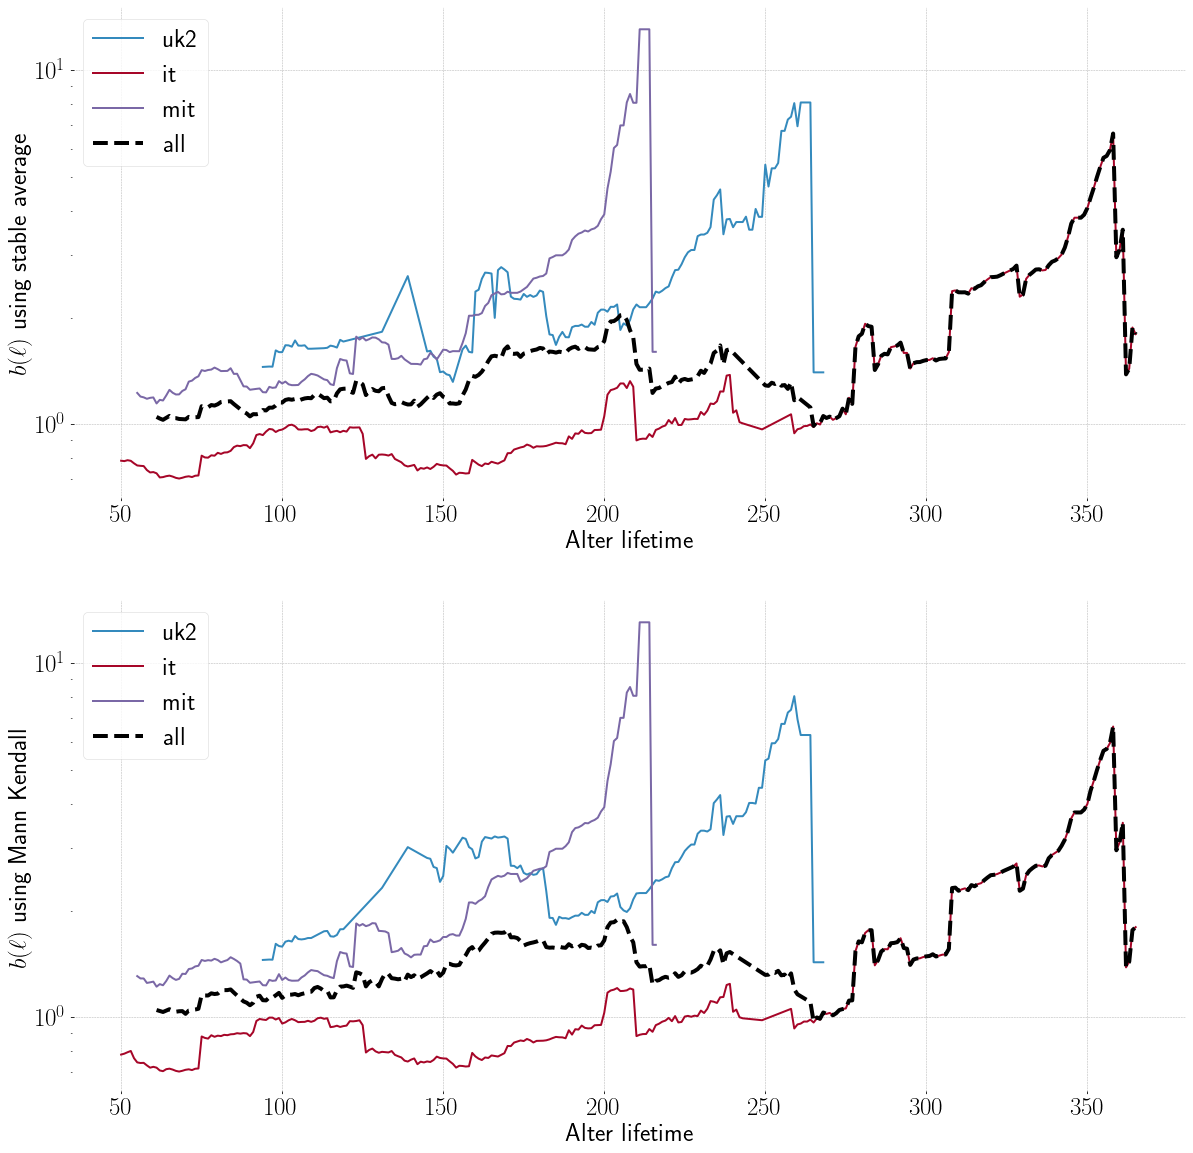

In [509]:
plt.figure(figsize=(20*1, 10*2))
plt.subplot(211)
plt.semilogy()
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using stable average")
for c in ['uk2', 'it', 'mit', 'all']:
    df = b[c].loc[b[c]['convs'] == True]
    if c != 'all':
        plt.plot(df.index, df['slopes'], label=c)
    else:
        plt.plot(df.index, df['slopes'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

plt.subplot(212)
plt.semilogy()
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using Mann Kendall")
for c in ['uk2', 'it', 'mit', 'all']:
    df = b[c].loc[b[c]['convs'] == True]
    if c != 'all':
        plt.plot(df.index, df['mk'], label=c)
    else:
        plt.plot(df.index, df['mk'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

In [511]:
binsize = 50
bbins = {}
for c in b.keys():
    df = b[c].loc[b[c]['convs'] == True]
    df2 = df[['slopes', 'mk']].copy()
    df2['lambda'] = df.index.map(lambda x: x // binsize)
    bbins[c] = df2.groupby('lambda').mean()
    bbins[c]['x'] = bbins[c].index.map(lambda x: (x * binsize) + (binsize // 2))

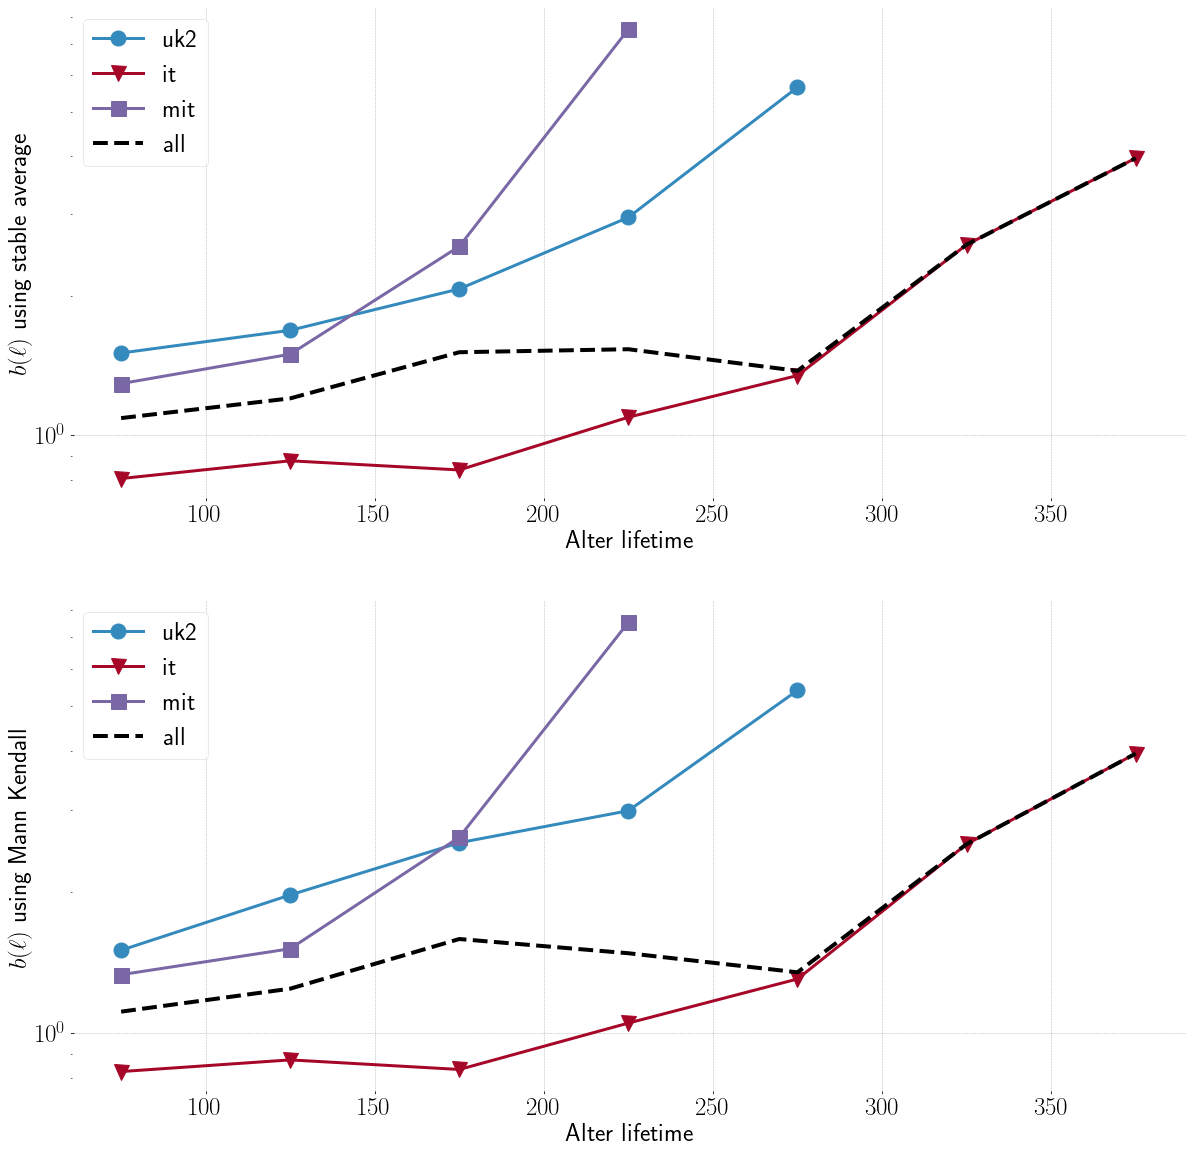

In [520]:
plt.figure(figsize=(20*1, 10*2))
plt.subplot(211)
plt.semilogy()
# plt.xlim(30, 370)
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using stable average")
m = -1
for c in ['uk2', 'it', 'mit', 'all']:
    if c != 'all':
        m += 1
        plt.plot(bbins[c]['x'], bbins[c]['slopes'], marker=markers[m], markersize=15, ls="solid", lw=3, 
                 c=colors[m], label=c)
    else:
        plt.plot(bbins[c]['x'], bbins[c]['slopes'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

plt.subplot(212)
plt.semilogy()
# plt.xlim(30, 370)
plt.xlabel(r"Alter lifetime")
plt.ylabel(r"$b(\ell)$ using Mann Kendall")
m = -1
for c in ['uk2', 'it', 'mit', 'all']:
    if c != 'all':
        m += 1
        plt.plot(bbins[c]['x'], bbins[c]['mk'], marker=markers[m], markersize=15, ls="solid", lw=3, 
                 color=colors[m], label=c)
    else:
        plt.plot(bbins[c]['x'], bbins[c]['mk'], ls = "dashed", c="black", lw=4, label=c)
plt.legend()

In [522]:
tmp = pd.DataFrame()
for c in bbins.keys():
    # df = bbins[c].loc[bbins[c]['x'] < 300]
    df = bbins[c].copy(deep=True)
    df.columns = [f's{c}', f'm{c}', f'x{c}']
    tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", index=False, header=True, sep="\t")

In [519]:
tmp

suk2      muk2  xuk2       sit       mit  xit      smit      mmit  \
lambda                                                                          
1       1.087599  1.109490    75  1.087599  1.109490   75  1.087599  1.109490   
2       1.199705  1.242235   125  1.199705  1.242235  125  1.199705  1.242235   
3       1.509500  1.586389   175  1.509500  1.586389  175  1.509500  1.586389   
4       1.532226  1.479085   225  1.532226  1.479085  225  1.532226  1.479085   
5       1.375976  1.346604   275  1.375976  1.346604  275  1.375976  1.346604   

        xmit      sall      mall  xall  
lambda                                  
1         75  1.087599  1.109490    75  
2        125  1.199705  1.242235   125  
3        175  1.509500  1.586389   175  
4        225  1.532226  1.479085   225  
5        275  1.375976  1.346604   275

## Distribution of $b_i(\ell)$

In [548]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [549]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.665214233841685, 0.01) (0.665214233841685, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.1165376495425756, 0.01) (1.1165376495425756, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.775213675213675, 0.01) (1.775213675213675, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.3761609907120743, 0.01) (0.3761609907120743, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.5263636363636363, 0.01) (0.5263636363636363, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(0.7938339920948616, 0.01) (0.7938339920948616, 1)};
=====================mit========================
\addplot[dashed, charmander, line width = 4] coordinates {(1.1664197530864198, 0.01) (1.1664197530864198, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.7407407407407408, 0.01) (0.740740740

In [550]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", index=False, header=True, sep="\t")

### Now using mann kendall

In [551]:
bhist2 = {}
for c in fig1.keys():
    bhist2[c] = {}
    for lamb in fig1[c].keys():
        bhist2[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve2 = fig1[c][lamb]['fi'][ego]
            if len(curve2) > 1:
                b = pc.get_b_mk(curve2)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist2[c][lamb].append(b[1][1])

In [552]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist2[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5b.dat", index=False, header=True, sep="\t")

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.665214233841685, 0.01) (0.665214233841685, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.1165376495425756, 0.01) (1.1165376495425756, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.775213675213675, 0.01) (1.775213675213675, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.3761609907120743, 0.01) (0.3761609907120743, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.5263636363636363, 0.01) (0.5263636363636363, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(0.7938339920948616, 0.01) (0.7938339920948616, 1)};
=====================mit========================
\addplot[dashed, charmander, line width = 4] coordinates {(1.1664197530864198, 0.01) (1.1664197530864198, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.7679012345679012, 0.01) (0.767901234

## $p$-value distribution for the KS test

In [557]:
ksp = {}
for c in ['uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8174603174603173, 0.04) (0.8174603174603173, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7072727272727272, 0.04) (0.7072727272727272, 1)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.811798371120405, 0.04) (0.811798371120405, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.8344573748163687, 0.04) (0.8344573748163687, 1)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.9067857142857143, 0.04) (0.9067857142857143, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.843990755007704, 0.04) (0.843990755007704, 1)};


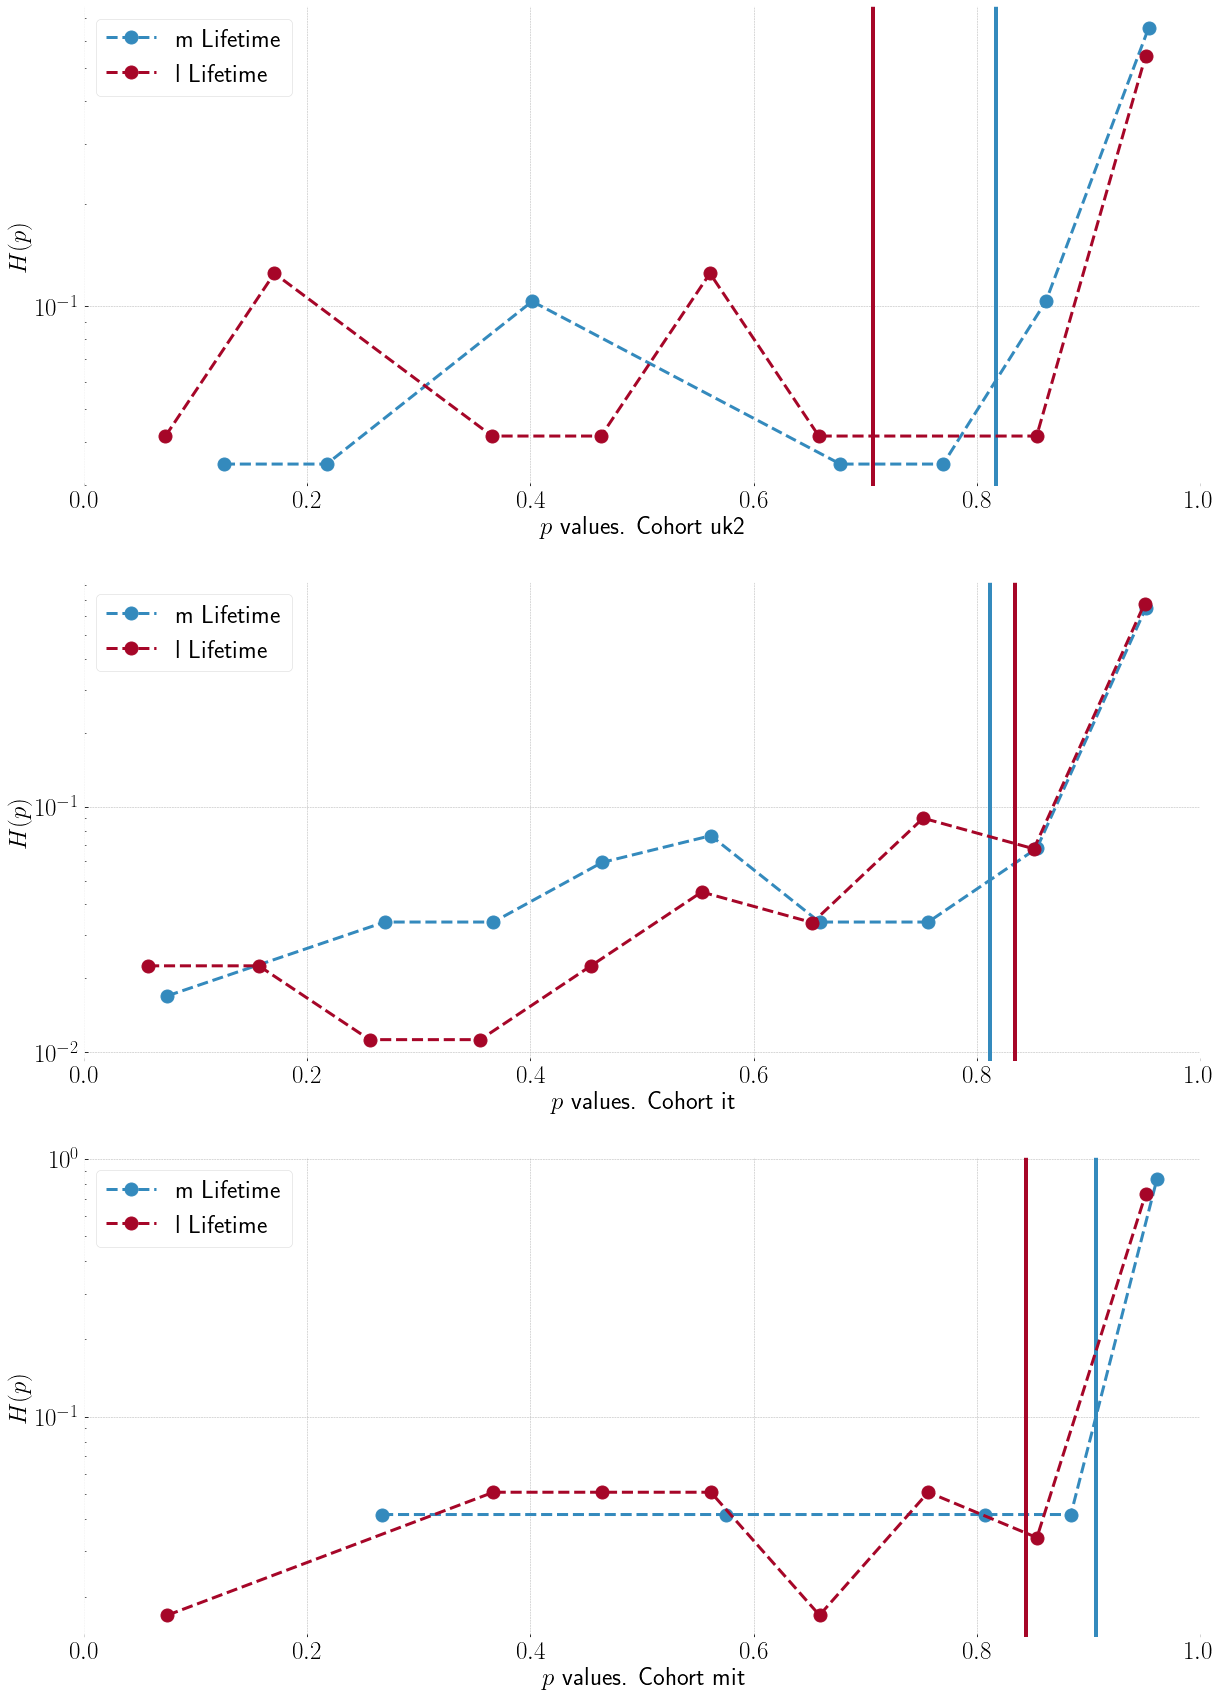

In [558]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20, 10*3))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(3,1, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.04) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1

In [559]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S6.dat", index=False, header=True, sep="\t")

## Identify $\ell_s$ for each cohort



In [560]:
def get_ells(bdf, col, lookforward=15):
    df = bdf[[col]].rolling(lookforward).mean()
    df2 = df.loc[df[col] == 1]
    if len(df2) > 0:
        return min(df2.index)
    else:
        return None

In [561]:
egolist = {}
for c in ['uk2', 'it', 'mit']:
    egolist[c] = [ego for ego in calls[c]['ego'].unique()]

In [562]:
t0 = dt.datetime.now()
bi = {}
bi2 = {}
convergei = {}
convergei2 = {}
niter = {}
for c in ['uk2', 'it', 'mit']:
    bi[c] = {}
    bi2[c] = {}
    convergei[c] = {}
    convergei2[c] = {}
    niter[c] = {}
    dff = pc.get_f(calls[c], 'all', 15, 10)
    for ego in dff.keys():
        bi[c][ego] = {}
        bi2[c][ego] = {}
        convergei[c][ego] = {}
        convergei2[c][ego] = {}
        niter[c][ego] = {}
        dffl = {ego: dff[ego]}
        for ell in range(301):
            curve = pc.get_avgfa(dffl, lives[c], ell, ell + 50)
            if (curve is not None) and (len(curve) > 3):
                points = pc.get_b_slopes(curve, FlagConverge=True)
                points2 = pc.get_b_mk(curve, FlagConverge=True)
                bi[c][ego][ell] = points[1][1]
                bi2[c][ego][ell] = points2[1][1]
                convergei[c][ego][ell] = points[2]
                convergei2[c][ego][ell] = points2[2]
                niter[c][ego][ell] =  points2[3]
        if len(bi[c][ego].keys()) > 0:
            bi[c][ego] = pd.DataFrame.from_dict(bi[c][ego], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
            tmp = pd.DataFrame.from_dict(convergei[c][ego], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
            if ego in bi2[c].keys():
                tmpb2 = pd.DataFrame.from_dict(bi2[c][ego], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
                tmpc2 = pd.DataFrame.from_dict(convergei2[c][ego], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
            bi[c][ego] = bi[c][ego].merge(tmp, left_index=True, right_index=True, how='outer')
            if ego in bi2[c].keys():
                bi[c][ego] = bi[c][ego].merge(tmpb2, left_index=True, right_index=True, how='outer')
                bi[c][ego] = bi[c][ego].merge(tmpc2, left_index=True, right_index=True, how='outer')
                bi[c][ego]['mam'] = bi[c][ego]['mk'].rolling(window=50).mean()
            bi[c][ego]['mas'] = bi[c][ego]['slopes'].rolling(window=50).mean()
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:05:13.140911


In [563]:
for ego in bi['mit'].keys():
    if type(bi['mit'][ego]) == pd.core.frame.DataFrame:
        print(np.mean(bi['mit'][ego]['convs']))

0.0
0.4745762711864407
0.8058252427184466
0.8333333333333334
1.0
1.0
0.3221476510067114
0.839622641509434
0.6451612903225806
0.8855421686746988
0.0
1.0
0.7301587301587301
0.7738095238095238
0.6474358974358975
0.7132352941176471
0.22142857142857142
0.8023255813953488
0.4322916666666667
0.7584269662921348
0.6829268292682927
0.6214689265536724
0.6140350877192983
0.058333333333333334
0.0
0.6111111111111112
0.52
0.5588235294117647
0.9636363636363636
1.0
0.6984126984126984
0.7132867132867133
0.6859903381642513
0.0
1.0
1.0
1.0
0.4943181818181818
1.0
0.0
0.0
1.0
1.0
0.51
0.5188679245283019
0.6714285714285714
0.9119496855345912
0.6228571428571429
0.6888888888888889
0.0392156862745098
0.17777777777777778
0.9809523809523809
0.9444444444444444
1.0
0.37362637362637363
0.0
0.8717948717948718
0.796875
0.9230769230769231
1.0
1.0
0.4791666666666667
0.0
1.0
0.4117647058823529
0.6375
0.08928571428571429
0.6764705882352942
0.5730337078651685
0.0
1.0
0.49038461538461536
0.0
0.0
0.6197183098591549
0.7647058

In [564]:
bif = {}
bif['all'] = {}
for c in bi.keys():
    bif[c] = {}
    for ego in bi[c].keys():
        if type(bi[c][ego]) == pd.core.frame.DataFrame:
            bif[c][ego] = bi[c][ego]
            bif['all'].update(bif[c])

In [566]:
for c in ['uk2', 'it', 'mit']:
    for ego in bif[c].keys():
        if ego not in bif['all'].keys():
            print('problem with', c, ego)
    else:
        print('success!', c)

success! uk2
success! it
success! mit


In [567]:
ellsHs = {}
for c in bif.keys():
    ellsHs[c] = pc.histogram([get_ells(bif[c][ego], 'convs', lookforward=10) for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None], 10, log=False)

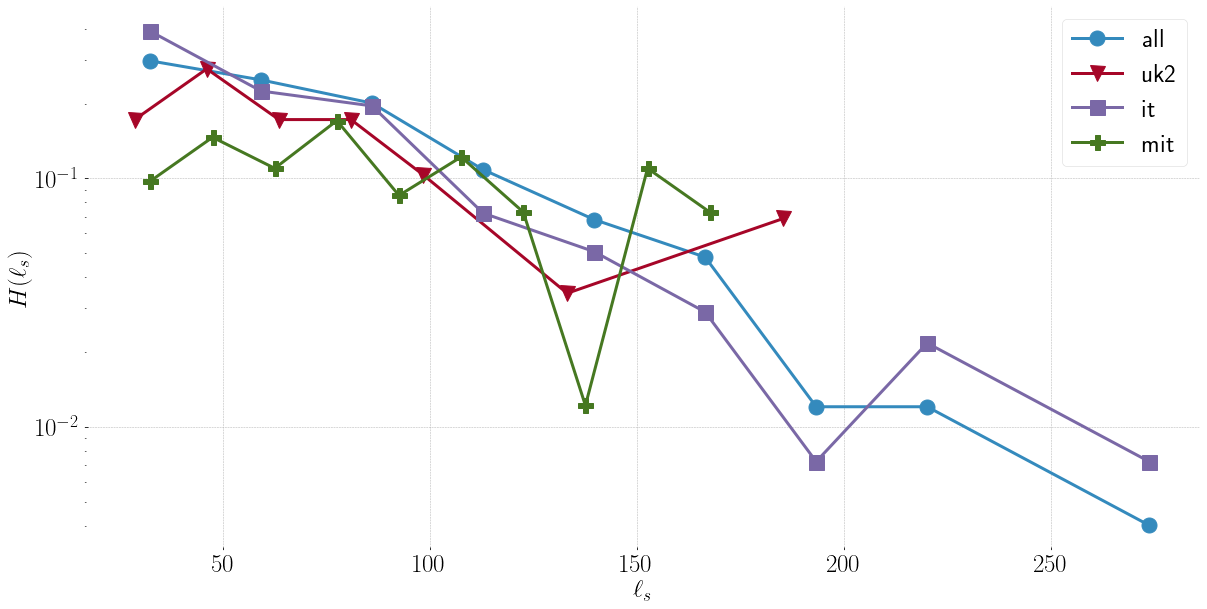

In [568]:
plt.semilogy()
plt.xlabel(r'$\ell_s$')
plt.ylabel(r'$H(\ell_s)$')
m = 0
for c in ellsHs.keys():
    plt.plot(ellsHs[c]['label'], ellsHs[c]['pmf'], marker=markers[m], ls="solid", markersize=15, lw=3, label=f'{c}')
    m += 1
plt.legend()

In [ ]:
ellsHm = {}
for c in bif.keys():
    listells = [get_ells(bif[c][ego], 'convm') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convm') is not None]
    if len(listells) > 0:
        ellsHm[c] = pc.histogram(listells, 10, log=False)

In [569]:
tmp = pd.DataFrame()
for c in ellsHs.keys():
    print(f'================{c}=====================')
    H = ellsHs[c].copy(deep=True)
    H['tmp'] = H['label'] * H['h']
    avg = sum(H['tmp']) / sum(H['h'])
    print(avg)
    H = H[['label', 'pmf']]
    H = H.rename({'label': f'x{c}', 'pmf': f'y{c}'}, axis='columns')
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S9.dat", index=False, header=True, sep="\t")

================all=====================
77.49718875502008
================uk2=====================
70.1
================it=====================
71.04637681159421
================mit=====================
90.85365853658537


In [ ]:
tmp

### Estimation from a regression

In [570]:
ellsHs['all']['logp'] = np.log(ellsHs['all']['pmf'])
ellsHs['all']

h       pmf  label      logp
0  74  0.297189   32.4 -1.213388
1  62  0.248996   59.2 -1.390319
2  50  0.200803   86.0 -1.605430
3  27  0.108434  112.8 -2.221616
4  17  0.068273  139.6 -2.684240
5  12  0.048193  166.4 -3.032546
6   3  0.012048  193.2 -4.418841
7   3  0.012048  220.0 -4.418841
9   1  0.004016  273.6 -5.517453

In [571]:
Y = np.array(ellsHs['all']['logp'])
X = np.array(ellsHs['all']['label'])
X = sm.add_constant(X)

In [572]:
model = sm.OLS(Y, X)
result = model.fit()
result.summary()

/home/vsvh/.local/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     189.2
Date:                Thu, 10 Feb 2022   Prob (F-statistic):           2.53e-06
Time:                        00:36:37   Log-Likelihood:                -1.0797
No. Observations:                   9   AIC:                             6.159
Df Residuals:                       7   BIC:                             6.554
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2177      0.223     -0.974      0.362      -0.746       0.311
x1            -0.0191      0.001    -13.754      0.000      -0.022      -0.016
==============================================================================
Omnibus:                        0.972   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                0.718
Skew:                          -0.570   Prob(JB):                        0.698
Kurtosis:                       2.215   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [573]:
result.params

array([-0.21768728, -0.01912678])

In [574]:
np.exp(result.params[0])

0.80437694342788

In [575]:
-1 / result.params[1]

52.28271034314185

In [576]:
for c in bif.keys():
    thelist = [get_ells(bif[c][ego], 'convs') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None]
    print(c, np.mean(thelist), min(thelist))

all 84.63855421686748 24
uk2 76.34482758620689 25
it 79.94927536231884 24
mit 95.46341463414635 30


## Fig 3 separated by country

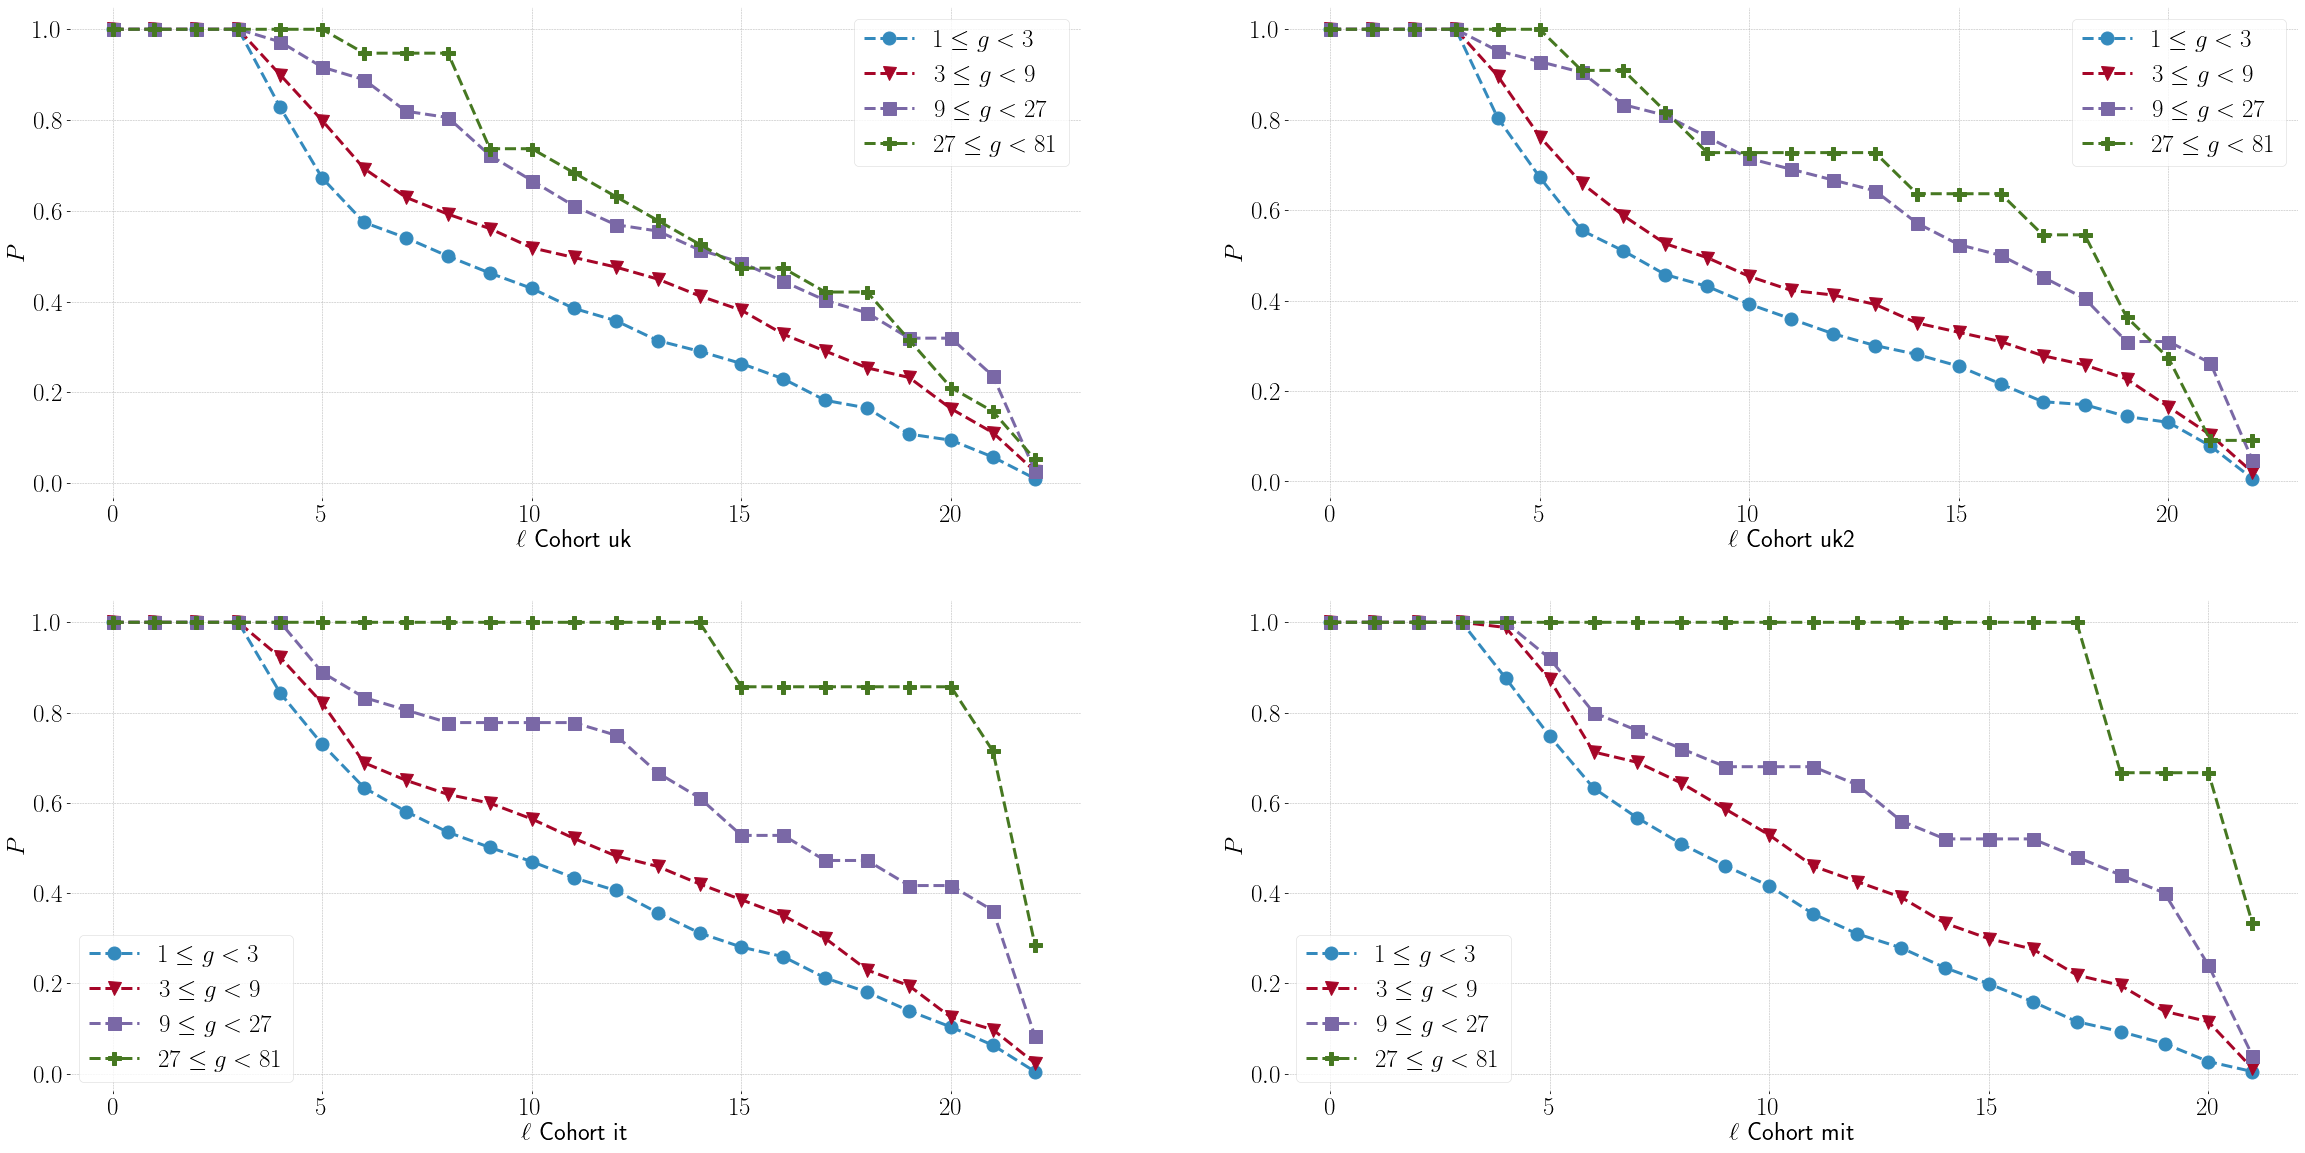

In [353]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(4):
        plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${3**i} \leq g < {3**(i + 1)}$')
    plt.legend()
    p += 1

In [354]:
tmp = pd.DataFrame()
for c in ['uk', 'uk2', 'mit', 'it']:
    for i in range(4):
        tmp[f'{c}{i}'] = fig3b[c][i]
        
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S7.dat", index=True, header=True, sep="\t")

In [355]:
tmp

uk0       uk1       uk2       uk3      uk20      uk21      uk22  \
a                                                                           
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
20   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
30   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
40   0.827703  0.899471  0.972222  1.000000  0.803922  0.896907  0.952381   
50   0.672297  0.798942  0.916667  1.000000  0.673203  0.762887  0.928571   
60   0.574324  0.693122  0.888889  0.947368  0.555556  0.659794  0.904762   
70   0.540541  0.629630  0.819444  0.947368  0.509804  0.587629  0.833333   
80   0.500000  0.592593  0.805556  0.947368  0.457516  0.525773  0.809524   
90   0.462838  0.560847  0.722222  0.736842  0.431373  0.494845  0.761905   
100  0.429054  0.518519  0.666667  0.736842  0.392157  0.453608  0.714286   
110  0.385135  0.497354  0.611111  0.684211  0.359477  0.422680  0.690476   
120  0.358108  0.476190  0.569444  0.631579  0.326797  0.412371  0.666667   
130  0.314189  0.449735  0.555556  0.578947  0.300654  0.391753  0.642857   
140  0.290541  0.412698  0.513889  0.526316  0.281046  0.350515  0.571429   
150  0.263514  0.380952  0.486111  0.473684  0.254902  0.329897  0.523810   
160  0.229730  0.328042  0.444444  0.473684  0.215686  0.309278  0.500000   
170  0.182432  0.291005  0.402778  0.421053  0.176471  0.278351  0.452381   
180  0.165541  0.253968  0.375000  0.421053  0.169935  0.257732  0.404762   
190  0.108108  0.232804  0.319444  0.315789  0.143791  0.226804  0.309524   
200  0.094595  0.164021  0.319444  0.210526  0.130719  0.164948  0.309524   
210  0.057432  0.111111  0.236111  0.157895  0.078431  0.103093  0.261905   
220  0.010135  0.026455  0.027778  0.052632  0.006536  0.020619  0.047619   

         uk23      mit0      mit1  mit2      mit3       it0       it1  \
a                                                                       
0    1.000000       1.0       1.0   1.0       1.0  1.000000  1.000000   
10   1.000000       1.0       1.0   1.0       1.0  1.000000  1.000000   
20   1.000000       1.0       1.0   1.0       1.0  1.000000  1.000000   
30   1.000000       1.0       1.0   1.0       1.0  1.000000  1.000000   
40   1.000000  0.876106  0.988506   1.0       1.0  0.843049  0.922179   
50   1.000000  0.747788  0.873563  0.92       1.0  0.729821  0.821012   
60   0.909091  0.632743  0.712644   0.8       1.0  0.633408  0.688716   
70   0.909091  0.566372  0.689655  0.76       1.0  0.580717  0.649805   
80   0.818182   0.50885  0.643678  0.72       1.0  0.534753  0.618677   
90   0.727273  0.460177  0.586207  0.68       1.0  0.501121  0.599222   
100  0.727273  0.415929  0.528736  0.68       1.0  0.469731  0.564202   
110  0.727273  0.353982   0.45977  0.68       1.0  0.433857  0.521401   
120  0.727273  0.309735  0.425287  0.64       1.0  0.405830  0.482490   
130  0.727273  0.278761  0.390805  0.56       1.0  0.356502  0.459144   
140  0.636364  0.234513  0.333333  0.52       1.0  0.311659  0.420233   
150  0.636364  0.199115  0.298851  0.52       1.0  0.280269  0.385214   
160  0.636364  0.159292  0.275862  0.52       1.0  0.258969  0.350195   
170  0.545455  0.115044  0.218391  0.48       1.0  0.211883  0.299611   
180  0.545455   0.09292  0.195402  0.44  0.666667  0.180493  0.229572   
190  0.363636  0.066372  0.137931   0.4  0.666667  0.139013  0.194553   
200  0.272727  0.026549  0.114943  0.24  0.666667  0.103139  0.124514   
210  0.090909  0.004425  0.011494  0.04  0.333333  0.062780  0.097276   
220  0.090909       nan       nan   nan       nan  0.004484  0.023346   

          it2       it3  
a                        
0    1.000000  1.000000  
10   1.000000  1.000000  
20   1.000000  1.000000  
30   1.000000  1.000000  
40   1.000000  1.000000  
50   0.888889  1.000000  
60   0.833333  1.000000  
70   0.805556  1.000000 

### Alternative function

In [ ]:
# plt.figure(figsize=(20*2, 10*2))
# p = 1
# for c in ['uk', 'uk2', 'it', 'mit']:
#     plt.subplot(2,2,p)
#     plt.xlabel(fr"$\ell$ Cohort {c}")
#     plt.ylabel(r"$P$")
#     for i in range(1,6):
#         plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
#     plt.legend()
#     p += 1

## Change values of $a_o$ and $a_f$ for fig3

In [356]:
elements = [(0, 15), (30, 45), (60, 75), (0, 30), (30, 60), (60, 90), (0, 45), (30, 75), (60, 105), (0, 60), (30, 90), (60, 120)]

In [359]:
t0 = dt.datetime.now()
Ssva = {}
for p in range(len(elements)):
    Ssva[p + 1] = pc.get_survival2(calls['all'], elements[p][0], elements[p][1], maxell=220, base=3)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.842802


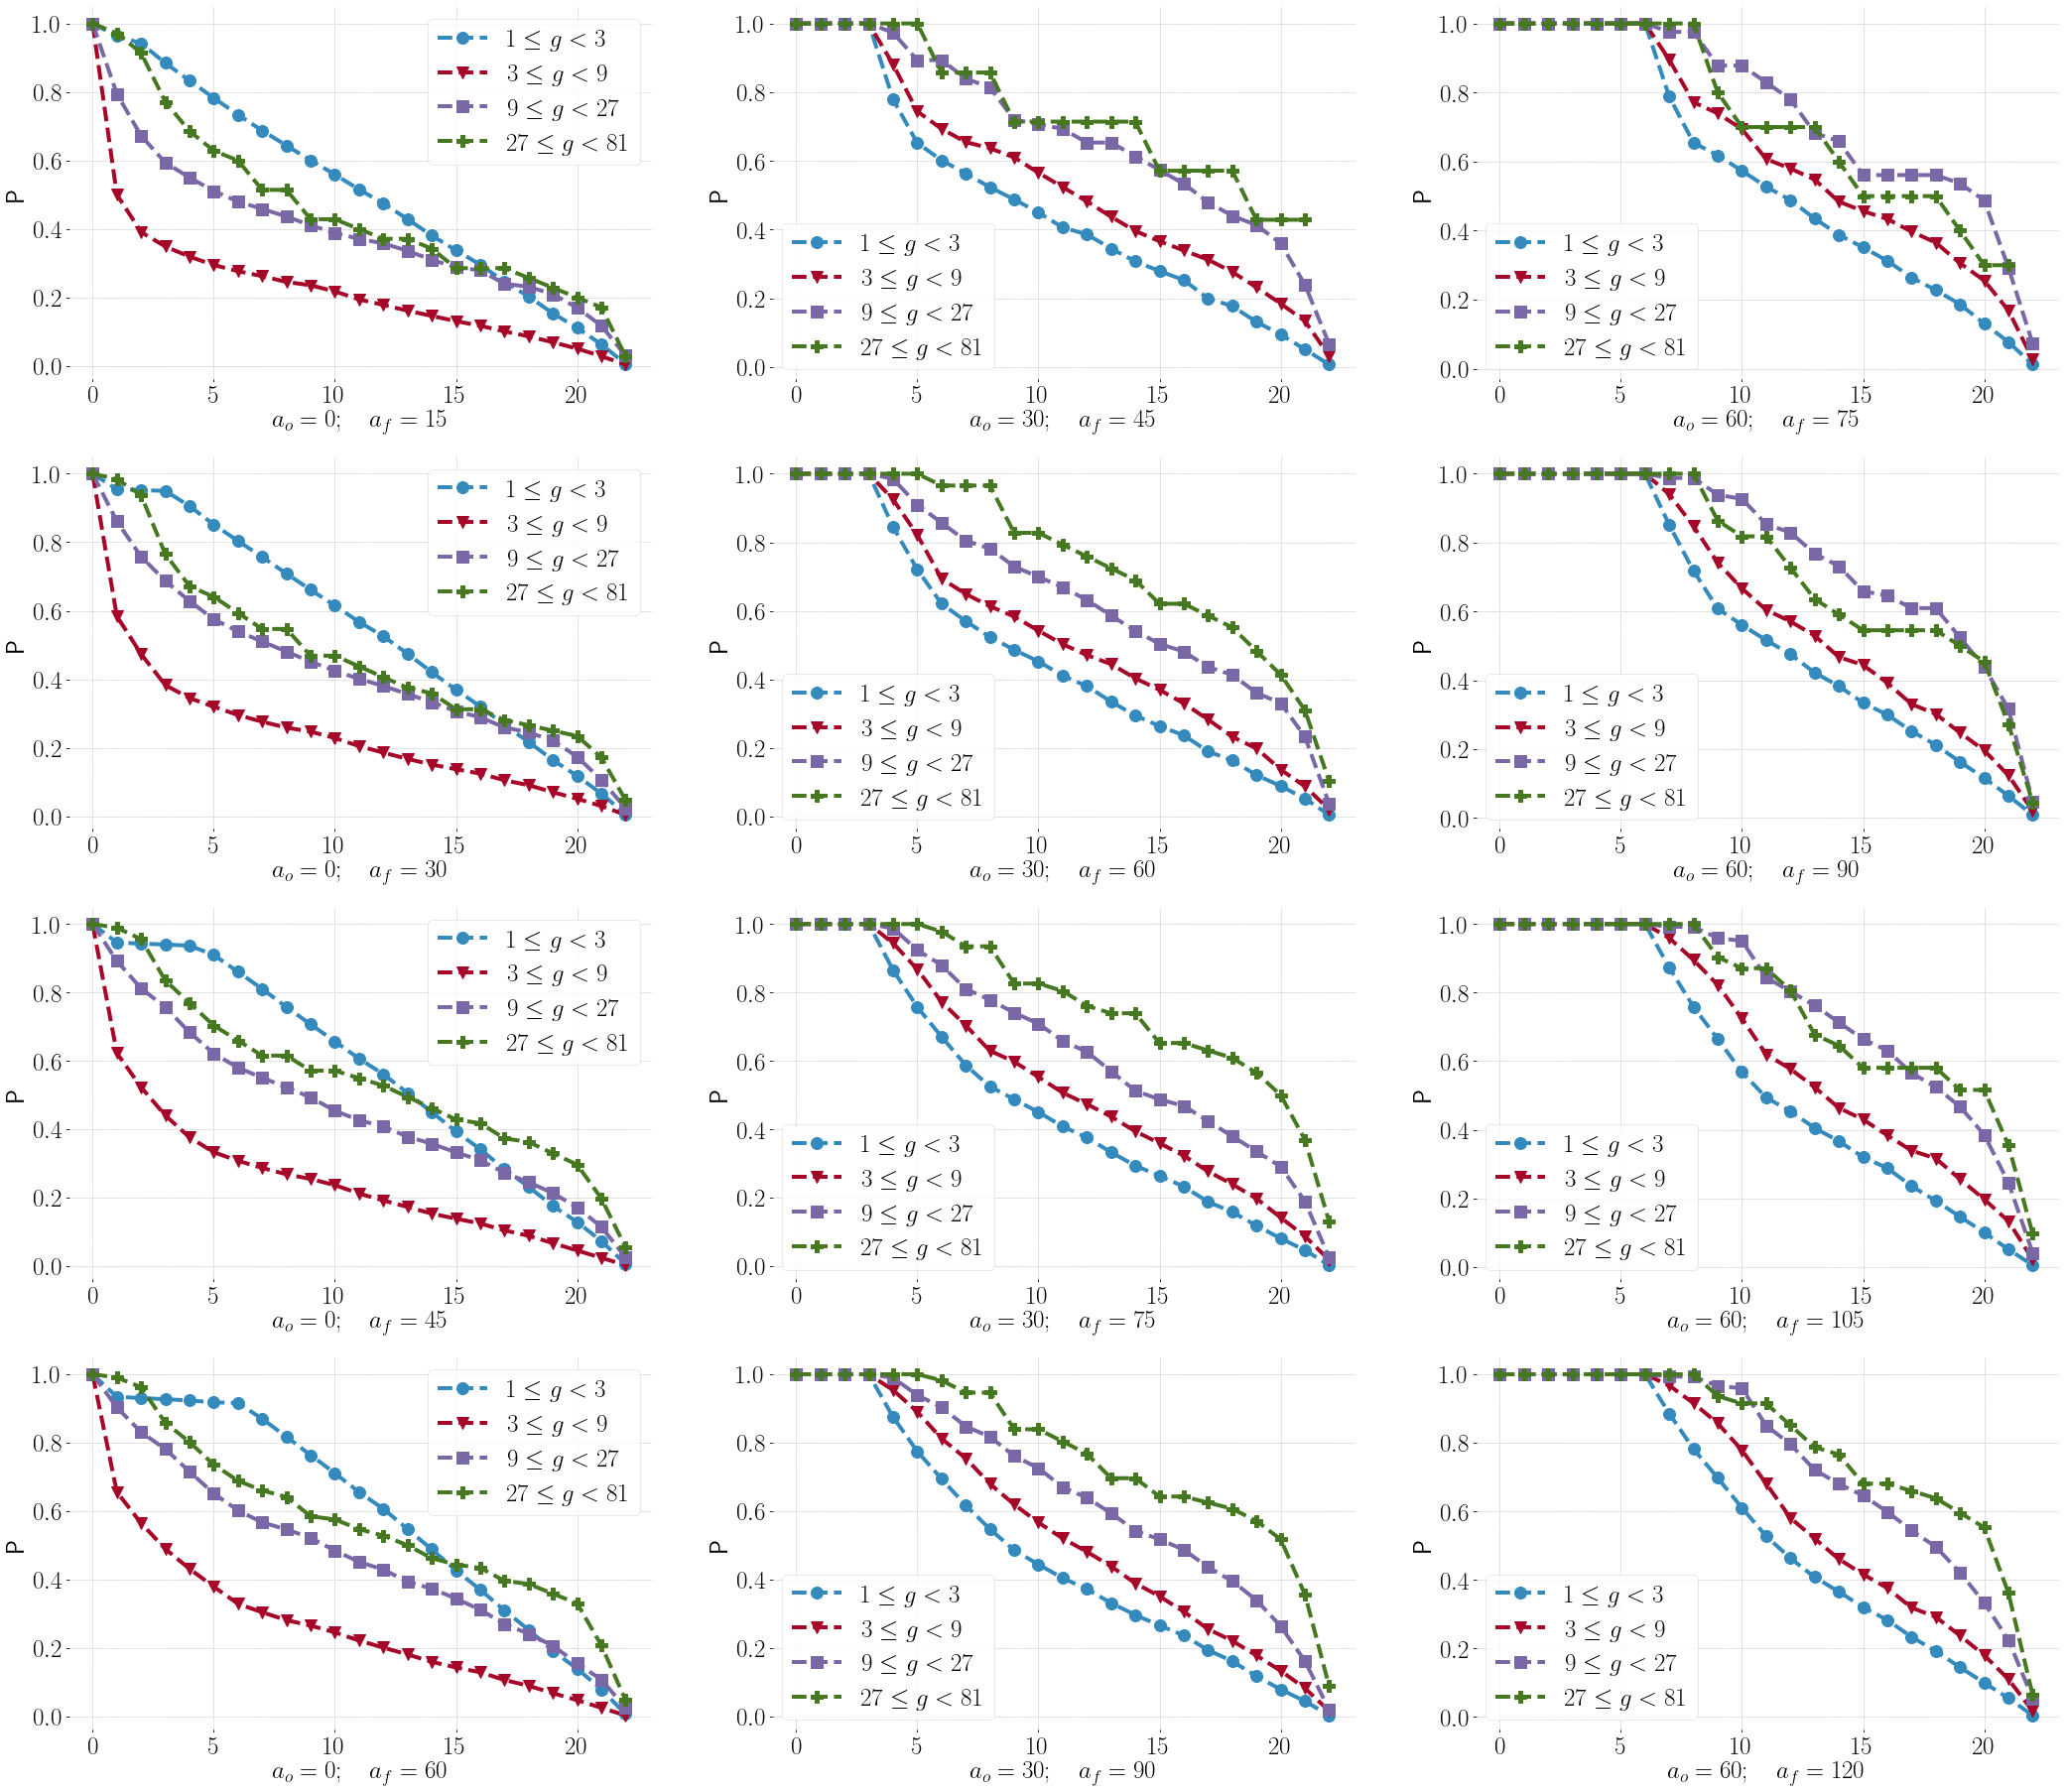

In [361]:
plt.figure(figsize=(12*3, 8*4))
for p in Ssva.keys():
    plt.subplot(4,3,p)
    plt.xlabel(fr'$a_o = {elements[p-1][0]}; \quad a_f = {elements[p-1][1]}$')
    plt.ylabel(r'P')
    for i in range(4):
        plt.plot(Ssva[p][i].index, Ssva[p][i]['p'], marker=markers[i], ls="dashed", lw=4, markersize=12, label=fr'${3**i} \leq g < {3**(i + 1)}$')
    plt.legend()

In [363]:
tmp = pd.DataFrame()
for p in Ssva.keys():
    for i in range(4):
        df = Ssva[p][i].copy(deep=True)
        df.columns=[f'p{p}s{i}']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S8.dat", index=True, header=True, sep='\t')

In [ ]:
tmp

## Distribution of $g$

In [ ]:
# dffsurv.keys()

In [381]:
gcount = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    gcount[c] = {}
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    tot = df.groupby('ea')[['time']].count().rename({'time': 'tot'}, axis='columns')
    gcount[c]['all'] = list(tot['tot'])
    df1 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    samp = df1.groupby('ea')[['time']].count().rename({'time': 'samp'}, axis='columns')
    gcount[c]['sample'] = list(samp['samp'])

In [369]:
gcount.keys()

dict_keys(['uk', 'uk2', 'it', 'mit'])

In [380]:
len(gcount['uk']['all'])

30

In [400]:
ghist = {}
for c in gcount.keys():
    ghist[c] = {}
    for s in gcount[c].keys():
        ghist[c][s] = {}
        glist = gcount[c][s]
        for n in glist:
            gamma = int(math.log(n, 3))
            ghist[c][s][gamma] = ghist[c][s].get(gamma, 0) + 1
        ghist[c][s] = pd.DataFrame.from_dict(ghist[c][s], orient='index').sort_index()
        ghist[c][s]['pmf'] = ghist[c][s][0].div(sum(ghist[c][s][0]))
        ghist[c][s]['label'] = 3**ghist[c][s].index

In [401]:
ghist['uk2']['sample']

0       pmf  label
0  153  0.501639      1
1   97  0.318033      3
2   42  0.137705      9
3   11  0.036066     27
4    2  0.006557     81

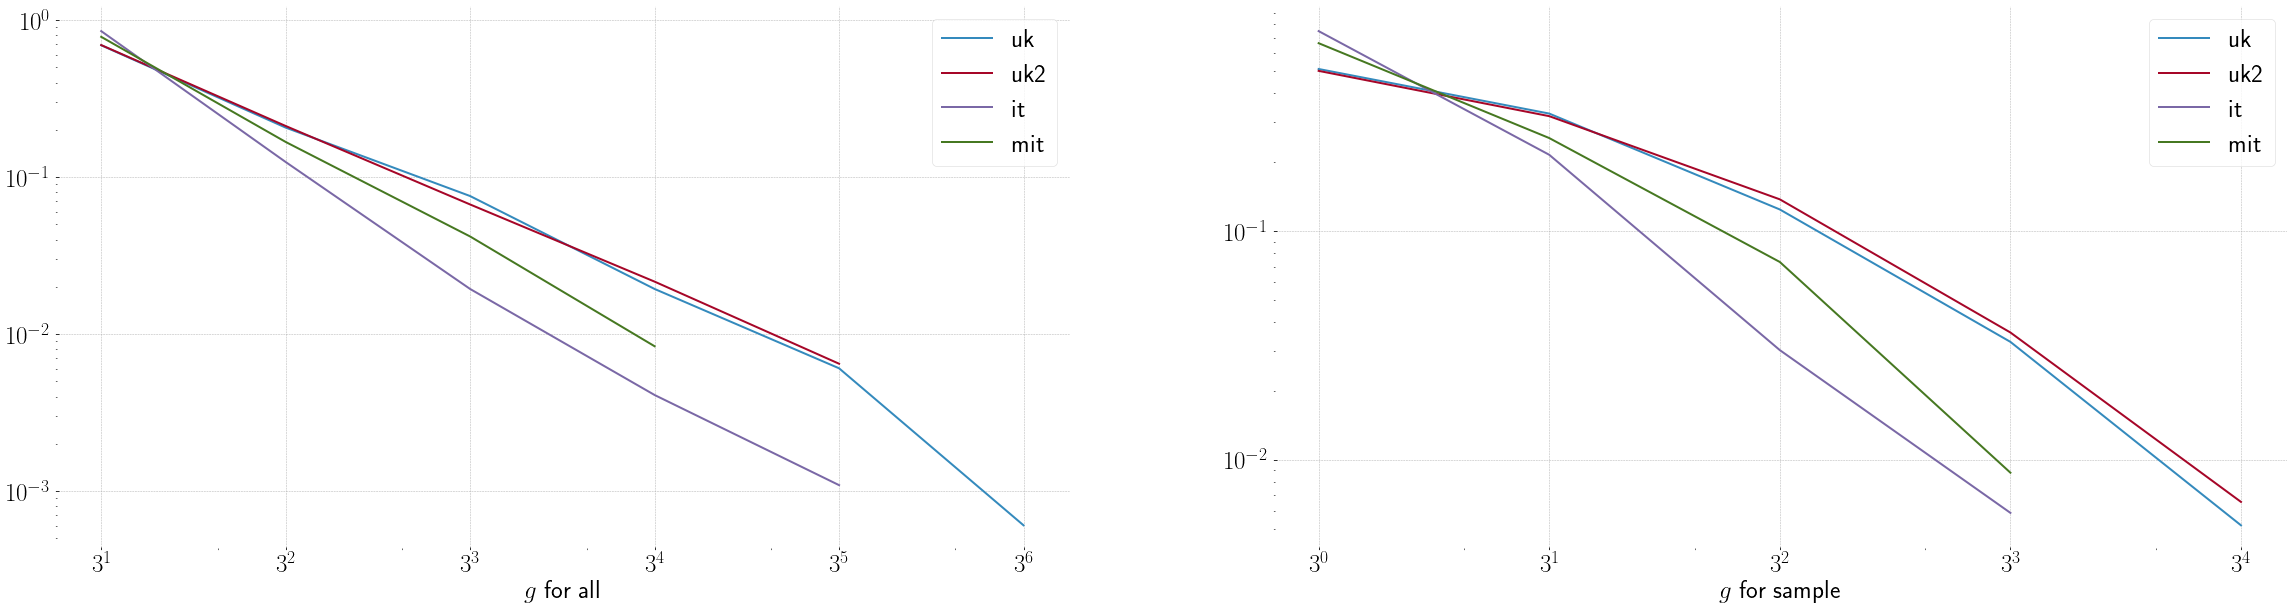

In [402]:
tmp = pd.DataFrame()
plt.figure(figsize=(20*2, 10*1))
p = 1
for s in ['all', 'sample']:
    plt.subplot(1,2,p)
    plt.xscale("log", base=3)
    plt.yscale("log")
    plt.xlabel(fr'$g$ for {s}')
    for c in ghist.keys():
        df = ghist[c][s]
        df2 = df[['pmf', 'label']]
        df2.columns = [f'p{dict({"all": "a", "sample": "s"})[s]}{c}', f'x{dict({"all": "a", "sample": "s"})[s]}{c}']
        tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
        plt.plot(df['label'], df['pmf'], label=c)
    plt.legend()
    p += 1
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S10.dat", index=False, header=True, sep="\t")

In [390]:
for c in gcount.keys():
    print(c, max(gcount[c]['all']), max(gcount[c]['sample']))

uk 1357 190
uk2 532 190
it 576 56
mit 243 48


In [403]:
3**6

729

## Fig 2 using Mann Kendall Estimation

In [553]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist2.keys():
    for ell in [1, 2]:
        thelist = bhist2[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2downb.dat", index=False, header=True, sep="\t")

In [554]:
cols = ['uk2m', 'itm', 'mitm', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,1,4,7]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 3]
b = tmp2.loc[tmp2.index >= 3]
a.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bmdownb.dat", index=True, header=True, sep="\t")
b.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bldownb.dat", index=True, header=True, sep="\t")

## Variation on fig4

In [ ]:
dffUI = {}
for c in ['uk', 'it']:
    dffUI.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffUI, alphafixed=(2,3), externalell=lives['all'], lambdamax=25)

In [ ]:
surv_cont.keys()

In [ ]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4ac.dat", header=False, index=False, sep="\t")

In [ ]:
points_mit = pc.get_survival(dffsurv['mit'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_mit.keys():
    if s <= 2**5 + 1:
        df = points_mit[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4ap{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

In [ ]:
dffMI = {}
for c in ['mit', 'it']:
    dffMI.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffMI, alphafixed=(2,3), externalell=lives['all'], lambdamax=25)

In [ ]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4bc.dat", header=False, index=False, sep="\t")

In [ ]:
points_uk = pc.get_survival(dffsurv['uk'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_uk.keys():
    if s <= 2**5 + 1:
        df = points_uk[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4bp{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

# Proportion of phone calls used after filters

In [ ]:
# t0 = dt.datetime.now()
# tmp = {}
# for c in ['uk', 'uk2', 'it', 'mit']:
#     tmp[c] = pc.lives_dictionary(unfiltered[c])
    
# counts = {}
# for c in ['uk', 'uk2', 'it', 'mit']:
#     alters = 0
#     ncalls = 0
#     a = 0
#     cc = 0
#     counts[c] = {}
#     for i in range(0, 301, 10):
#         tmpc = pc.apply_filters(unfiltered[c], i)
#         cdf = tmpc.loc[tmpc['aclock'] <= 300]
#         tmpl = pc.lives_dictionary(cdf)
#         tmpdff = pc.get_f(cdf, 'all', 15, 10)
#         for ego in tmp[c].keys():
#             for alter in tmp[c][ego].keys():
#                 vol = tmp[c][ego][alter]['nij']
#                 alters += 1
#                 ncalls += vol
#                 if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
#                     a += 1
#                     vol = tmpl[ego][alter]['nij']
#                     cc += vol
#             counts[c][i] = (a / alters, cc / ncalls)
#     counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))
    
# print(f'This block took {dt.datetime.now() - t0}')

# Mutual Information

In [ ]:
def get_month2(dff, lives):
    result = pd.DataFrame()
    idx = 0
    for ego in dff.keys():
        for alter in dff[ego].keys():
            df = dff[ego][alter].loc[(dff[ego][alter]['alpha'] >= 2) & (dff[ego][alter]['alpha'] <= 3)]
            if (len(df) > 0) and (ego in lives.keys()):
                result.at[idx, 'ego'] = ego
                result.at[idx, 'alter'] = alter
                result.at[idx, 'g'] = sum(df['f'])
                result.at[idx, 'lambda'] = lives[ego][alter]['ell']
                idx += 1
    return result

In [ ]:
miall = []
for i in ['uk', 'uk2', 'it', 'mit', 'all']:
    miall.append(get_month2(dffsurv[i], lives['all']))

In [ ]:
import sklearn.metrics as sk
miplot = []
for i in miall:
    miplot.append(sk.mutual_info_score(i['g'], i['lambda']))
for i in range(len(miplot)):
    print(['uk', 'uk2', 'it', 'mit', 'all'][i],"\t", miplot[i],"\t", miplot[i]*1.44)

In [ ]:
entropies = []
for i in miall:
    X = stats.entropy([xx / sum(i["g"]) for xx in i['g']])
    Y = stats.entropy([yy / sum(i['lambda']) for yy in i['lambda']])
    entropies.append(np.mean([X, Y]))
    print(X, Y, np.mean([X, Y]))

In [ ]:
for i in range(len(miplot)):
    print(['uk', 'uk2', 'mit', 'it', 'all'][i],"\t", miplot[i],"\t", miplot[i] / entropies[i])

# Finding $\mathcal{L}$

Currently, without redefining the sample, the number of ego alter pairs used is

In [ ]:
# for c in dffcomb.keys():
#     pairs = 0
#     for ego in dffcomb[c].keys():
#         for alter in dffcomb[c][ego].keys():
#             pairs += 1
#     print(c, pairs)

Now, for Italy

In [ ]:
Hfap = {}
for c in ['uk', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    fap = df.groupby('ego')[['uclock']].min()
    Hfap[c] = pc.histogram(fap['uclock'], 50, log=False)
plt.title('First appeareance of ego')    
plt.semilogy()
for c in Hfap.keys():
    plt.plot(Hfap[c]['label'], Hfap[c]['pmf'], label=c)
plt.legend()

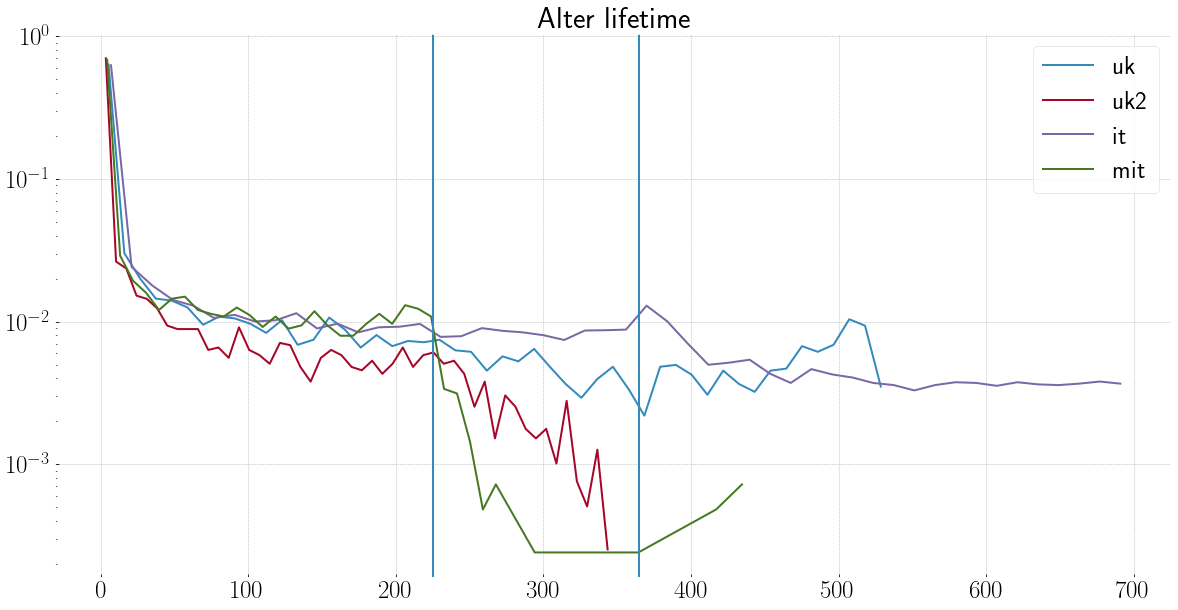

In [69]:
Hlf = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    Hlf[c] = pc.histogram(lf['aclock'], 50, log=False)
plt.title(r"Alter lifetime")
plt.semilogy()
# plt.xlim(-0.5, 365)
for c in Hlf.keys():
    plt.plot(Hlf[c]['label'], Hlf[c]['pmf'], label=c)
plt.axvline(225)
plt.axvline(365)
plt.legend()

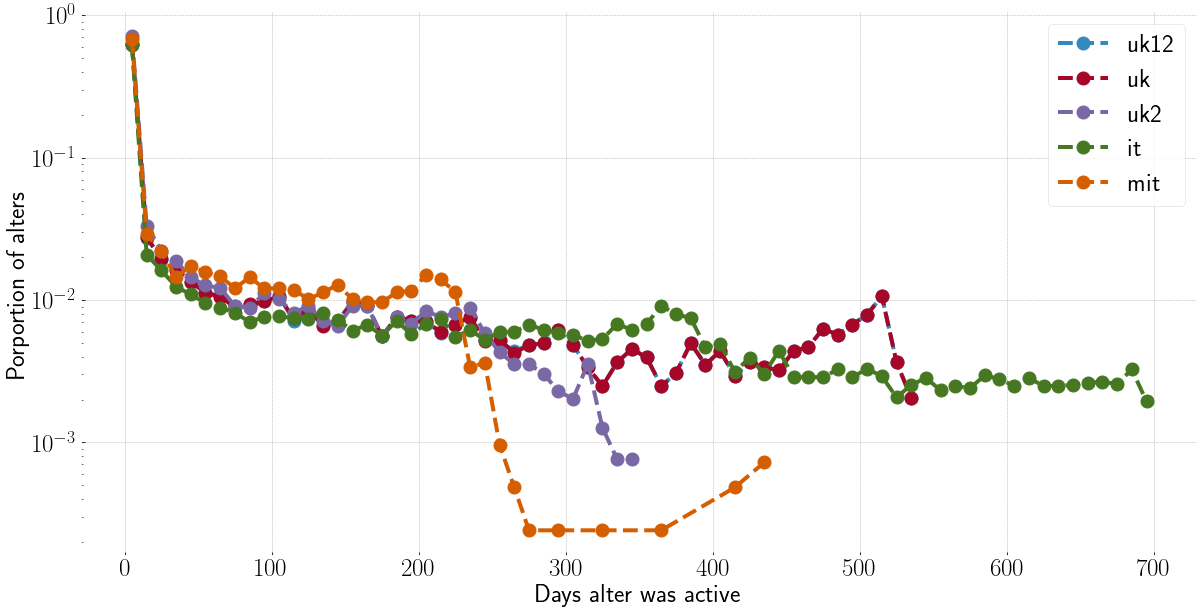

In [411]:
m = 0
tmp = pd.DataFrame()
plt.semilogy()
for c in ['uk12', 'uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    H = {}
    for ea in lf.index:
        ell = lf.at[ea, 'aclock'] // 10
        H[ell] = H.get(ell, 0) + 1
    H = pd.DataFrame.from_dict(H, orient='index').sort_index()
    H[f'x{c}'] = H.index.map(lambda i: (i * 10) + 5)
    H[f'y{c}'] = H[0].div(sum(H[0]))
    H = H.drop(columns=[0])
    plt.ylabel("Proportion of alters")
    plt.xlabel("Days alter was active")
    plt.plot(H[f'x{c}'], H[f'y{c}'], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
plt.legend()
plt.savefig("/home/vsvh/Desktop/A.pdf", dpi=200)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.dat", index=False, header=True, sep="\t")

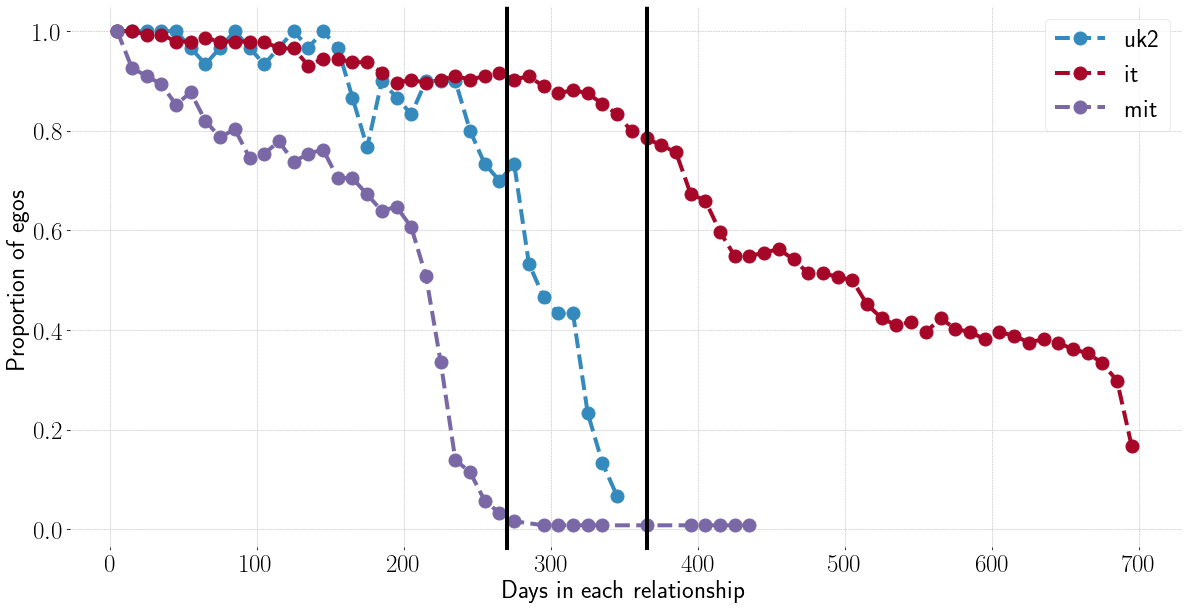

In [454]:
tmp = pd.DataFrame()
m = 0
#plt.semilogy()
for c in ['uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df['10d'] = df['aclock'].map(lambda i: (i // 10) + 0.5)
    nego = df.groupby('10d')[['ego']].nunique()
    n = len(df['ego'].unique())
    # plt.xlim(0, 400)
    plt.ylabel("Proportion of egos")
    nego.index = nego.index * 10
    plt.xlabel("Days in each relationship")
    plt.plot(nego.index, [y / n for y in nego['ego']], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    nego['ego'] /= n
    nego.columns = [f'y{c}']
    tmp = tmp.merge(nego, left_index=True, right_index=True, how='outer')
    plt.axvline(270, c="black", lw=4)
    plt.axvline(365, c="black", lw=4)
plt.legend()
# plt.savefig("/home/vsvh/Desktop/B.pdf", dpi=200)
# tmp = tmp.fillna('nan')
# tmp.index.rename("a", inplace=True)
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S0.dat", index=True, header=True, sep="\t")

In [455]:
tmp

yuk2       yit      ymit
a                             
5.0    1.0  1.000000       1.0
15.0   1.0  1.000000   0.92623
25.0   1.0  0.993056  0.909836
35.0   1.0  0.993056  0.893443
45.0   1.0  0.979167  0.852459
...    ...       ...       ...
655.0  nan  0.361111       nan
665.0  nan  0.354167       nan
675.0  nan  0.333333       nan
685.0  nan  0.298611       nan
695.0  nan  0.166667       nan

[70 rows x 3 columns]

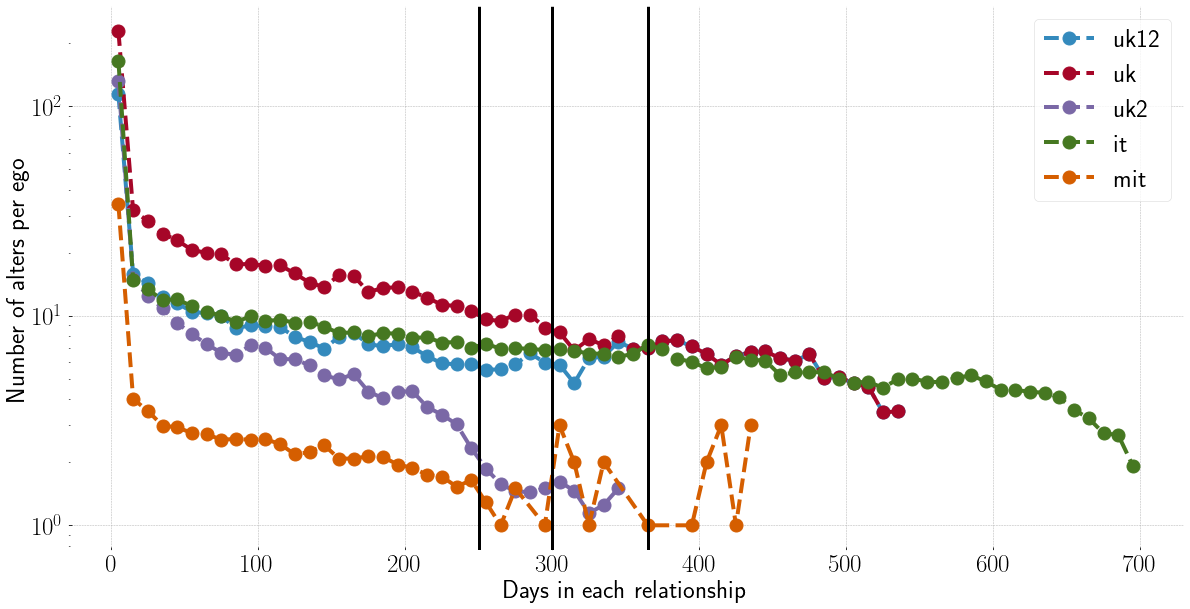

In [428]:
m = 0
plt.semilogy()
for c in ['uk12', 'uk', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df['10d'] = df['aclock'].map(lambda i: (i // 10) + 0.5)
    nalt = df.groupby('10d')[['ea']].nunique()
    nego = df.groupby('10d')[['ego']].nunique()
    prop = nego.merge(nalt, left_index = True, right_index = True, how='outer')
    prop['prop'] = prop['ea'] / prop['ego']
    plt.ylabel("Number of alters per ego")
    plt.xlabel("Days in each relationship")
    plt.plot([10 * x for x in prop.index], prop['prop'], marker=markers[m], markersize=13, ls="dashed", lw=4, label=c)
    plt.axvline(365, color='black', lw=3)
    plt.axvline(300, color='black', lw=3)
    plt.axvline(250, color='black', lw=3)
plt.legend()
plt.savefig("/home/vsvh/Desktop/C.pdf", dpi=200)

In [ ]:
it = unfiltered['it'].copy(deep=True)
it['ea'] = list(zip(it['ego'], it['alter']))
itlf = it.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
keep = itlf.loc[itlf['ell'] <= 365]
it = it[it['ea'].isin(keep.index)]
it = pc.apply_filters(it, 60)

In [ ]:
it['ea'] = list(zip(it['ego'], it['alter']))
print(len(it['ea'].unique()))
lf = it.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
H = pc.histogram(lf['ell'], 50, log=False)
plt.semilogy()
plt.plot(H['label'], H['pmf'])

In [ ]:
newlim = [(0, 50), (100, 150), (250, 300)]

In [ ]:
new1 = {}
for i in range(3):
    new1[i] = pc.get_fal(it, newlim[i][0], newlim[i][1], 15, countalters=True)

In [ ]:
plt.figure(figsize=(20*2, 10*1))
plt.subplot(121)
plt.title("New sampling")
plt.semilogy()
for i in range(3):
    plt.plot(new1[i]['f'].index, new1[i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()
plt.subplot(122)
plt.title("Sampling from the paper")
plt.semilogy()
for i in range(3):
    plt.plot(fig1['it'][i]['f'].index, fig1['it'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()

In [ ]:
new2 = {}
for i in range(3):
    new2[i] = pc.get_avgfa(dffcomb['uk'], lives['uk'], newlim[i][0], newlim[i][1])

In [ ]:
plt.figure(figsize=(20*2, 10*1))
plt.subplot(121)
plt.title("New sampling")
plt.semilogy()
for i in range(3):
    plt.plot(new2[i].index, new2[i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {newlim[i][1]}$')
plt.legend()
plt.subplot(122)
plt.title("Sampling from the paper")
plt.semilogy()
for i in range(3):
    plt.plot(fig1['uk'][i]['f'].index, fig1['uk'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()

In [ ]:
new3 = {}
for i in range(3):
    new3[i] = pc.get_avgfa(dffcomb['mit'], lives['mit'], newlim[i][0], newlim[i][1])

In [ ]:
plt.figure(figsize=(20*2, 10*1))
plt.subplot(121)
plt.title("New sampling")
plt.semilogy()
for i in range(3):
    plt.plot(new3[i].index, new3[i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${newlim[i][0]}\leq \ell \leq {newlim[i][1]}$')
plt.legend()
plt.subplot(122)
plt.title("Sampling from the paper")
plt.semilogy()
for i in range(3):
    plt.plot(fig1['mit'][i]['f'].index, fig1['mit'][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
plt.legend()

In [ ]:
egolist = {}
for c in ['it1', 'it2']:
    egolist[c] = [ego[1:] for ego in dffcomb[c].keys()]

intersections = {}
for ego in egolist['it1']:
    if ego in egolist['it2']:
        set1 = {alter for alter in dffcomb['it1'][f'a{ego}'].keys()}
        set2 = {alter for alter in dffcomb['it2'][f'b{ego}'].keys()}
        intersections[ego] = set1.intersection(set2)

In [ ]:
tot = 0
rep = 0
for ego in intersections.keys():
    tot += 1
    if len(intersections[ego]) > 0:
        rep += 1
print(f'Total egos: \t{tot}')
print(f'Egos with repetition: \t{rep} ({(rep/tot) * 100:.2f}%)')

In [ ]:
intersections

In [ ]:
a = unfiltered['it'].loc[(unfiltered['it']['ego'] == 28) & (unfiltered['it']['alter'] == '176577f07de42298c204581415ca579e')]
a

In [ ]:
max(a['uclock']) - min(a['uclock'])

In [ ]:
it.loc[(it['ego'] == 28) & (it['alter'] == '176577f07de42298c204581415ca579e')]

# Testing area

In [ ]:
general_count = 0
uk1_count = 0
for ego in dffcomb['uk'].keys():
    for alter in dffcomb['uk'][ego].keys():
        general_count += 1
        if ego[0] == 'a':
            uk1_count += 1
uk1_count / general_count

In [ ]:
min(unfiltered['it']['time'])

# Global Time

In [ ]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")